- Gaussian Mixture Model: SVGD v GSVGD vs HMC vs IAF flow
- Bayesian logistic regression: HMC v IAF Flow v
- Bayesian neural network
- Variational GP regression 

In [1]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import pandas as pd
import torch
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import MultivariateNormal
from pymanopt.manifolds import Grassmann
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import sys
sys.path.append("..")

alt.data_transformers.enable('default', max_rows=None)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

In [2]:
def get_density_chart(P, d=7.0, step=0.1):
    xv, yv = torch.meshgrid([
      torch.arange(-d, d, step), 
      torch.arange(-d, d, step)
    ])
    
    pos_xy = torch.cat((xv.unsqueeze(-1), yv.unsqueeze(-1)), dim=-1)
    p_xy = P.log_prob(pos_xy.to(device)).exp().unsqueeze(-1).cpu()
    print(p_xy.shape, pos_xy.shape)
    df = torch.cat([pos_xy, p_xy], dim=-1).numpy()
    df = pd.DataFrame({
      'x': df[:, :, 0].ravel(),
      'y': df[:, :, 1].ravel(),
      'p': df[:, :, 2].ravel(),
    })

    chart = alt.Chart(df).mark_point().encode(
    x='x:Q',
    y='y:Q',
    color=alt.Color('p:Q', scale=alt.Scale(scheme='viridis')),
    tooltip=['x','y','p']
    )

    return chart


def get_particles_chart(X):
    df = pd.DataFrame({
      'x': X[:, 0],
      'y': X[:, 1],
    })

    chart = alt.Chart(df).mark_circle(color='red').encode(
    x='x:Q',
    y='y:Q'
    )

    return chart

In [3]:
device

device(type='cpu')

In [4]:
from src.svgd import SVGD
from src.kernel import RBF

## Gaussian Mixture Model

$$q(x) = \frac{1}{3}\mathcal{N}(x;(-2, 0)^\intercal, I) + \frac{2}{3}\mathcal{N}(x;(2, 0)^\intercal, I)$$

Calculate $\mathbb{E}_q[X]$ using

HMC: 2 component mixture

In [5]:
from experiments.utils import GaussianMixture

In [6]:
repetitions = 1

In [96]:
# correlated Gaussian
mean = torch.Tensor([0,0]).to(device)
covariance = torch.Tensor([[1., 0.999], [0.999, 1.]]).to(device)
# covariance = torch.Tensor([[1., 0.5], [0.5, 1.]]).to(device)

distribution = torch.distributions.MultivariateNormal(mean, covariance)

$P_0X$

In [97]:
distribution.sample().shape

torch.Size([2])

In [106]:
## SVGD
pred_SVGD = []
for r in range(repetitions):
    
    num_particles = 100
    lr = 1e-2
    epochs = 500
    
    # sample from variational density
    torch.manual_seed(0)
    x_init = torch.randn(num_particles, *distribution.event_shape)
    x = x_init.clone().to(device)
    kernel = RBF(method="")
    svgd = SVGD(distribution, kernel, optim.Adam([x], lr=lr))
    for _ in tqdm(range(epochs)):
        svgd.step(x)
        
    pred_SVGD.append(x.mean(axis=0))

  0%|          | 0/500 [00:00<?, ?it/s]

In [107]:
fig = get_density_chart(distribution, d=5.0, step=0.1)

(fig + get_particles_chart(x_init.cpu().numpy())) | (fig + get_particles_chart(x.cpu().numpy()))

torch.Size([100, 100, 1]) torch.Size([100, 100, 2])


alt.HConcatChart(...)

In [145]:
import sys
from experiments.utils import GaussianMixture
from src.kernel import RBF
from src.gsvgd import GSVGD

# P = torch.Tensor([[1], [1]]).requires_grad_(True)
# x = torch.Tensor([[1, 0], [0, 1], [1, 2]]).requires_grad_(True)
# gauss = torch.distributions.MultivariateNormal(
#     loc = torch.Tensor([-0.6871,0.8010]),
#     covariance_matrix = 5 * torch.Tensor([[0.2260,0.1652],[0.1652,0.6779]])
# )

## Setup target parameters
num_particles = 100

torch.manual_seed(1)
x_init = torch.randn(num_particles, *distribution.event_shape)
x = x_init.clone()
A = torch.Tensor([[1], [0]]).requires_grad_(True)
# A = torch.Tensor([[1, 1], [0, 1]]).requires_grad_(True)

# k = RBF(method="med_heuristic")
k = RBF(method="med_heuristic")

manifold = Grassmann(2, 1)
optimizer = optim.Adam([x], lr=1e-2)

gsvgd = GSVGD(
    target=distribution,
    kernel=k,
    manifold=manifold,
    optimizer=optimizer
)
A = gsvgd.fit(x, A, epochs=100)

100%|██████████| 10000/10000 [02:56<00:00, 56.59it/s]


In [146]:
fig = get_density_chart(distribution, d=5.0, step=0.1)

(fig + get_particles_chart(x_init.cpu().numpy())) | (fig + get_particles_chart(x.cpu().numpy()))

torch.Size([100, 100, 1]) torch.Size([100, 100, 2])


alt.HConcatChart(...)

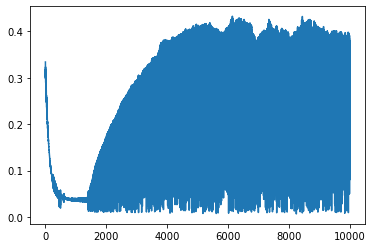

In [147]:
plt.plot(range(len(gsvgd.sigma_list)), np.array(gsvgd.sigma_list))

## optimize for $\sigma$

In [27]:
import sys
from experiments.utils import GaussianMixture
from src.kernel import RBF
from src.gsvgd import GSVGD

# P = torch.Tensor([[1], [1]]).requires_grad_(True)
# x = torch.Tensor([[1, 0], [0, 1], [1, 2]]).requires_grad_(True)
# gauss = torch.distributions.MultivariateNormal(
#     loc = torch.Tensor([-0.6871,0.8010]),
#     covariance_matrix = 5 * torch.Tensor([[0.2260,0.1652],[0.1652,0.6779]])
# )

## Setup target parameters
num_particles = 100

torch.manual_seed(0)
x_init = torch.randn(num_particles, *distribution.event_shape)
x = x_init.clone()
A = torch.Tensor([[1], [0]]).requires_grad_(True)
# A = torch.Tensor([[1, 1], [0, 1]]).requires_grad_(True)

# k = RBF()
k = RBF(method="optimize")
_ = k.forward(x.detach(), x.detach())

manifold = Grassmann(2, 1)
optimizer1 = optim.Adam([x], lr=1e-2)
sigma = torch.Tensor([1]).requires_grad_(True)
optimizer2 = optim.Adam([
        {"params": x}, 
        {"params": sigma, "lr": 1e-1}
    ], 
    lr=1e-2
)

gsvgd = GSVGD(
    target=distribution,
    kernel=k,
    manifold=manifold,
    optimizer=optimizer2
)
A = gsvgd.fit(x, A, sigma, epochs=300)


  1%|          | 2/300 [00:00<00:18, 16.17it/s]

before tensor([1.], requires_grad=True)
after tensor([1.1000], requires_grad=True)
before tensor([1.1000], requires_grad=True)
after tensor([1.1995], requires_grad=True)
before tensor([1.1995], requires_grad=True)
after tensor([1.2994], requires_grad=True)
before tensor([1.2994], requires_grad=True)
after tensor([1.3994], requires_grad=True)
before tensor([1.3994], requires_grad=True)


  3%|▎         | 8/300 [00:00<00:12, 22.90it/s]

after tensor([1.4998], requires_grad=True)
before tensor([1.4998], requires_grad=True)
after tensor([1.6001], requires_grad=True)
before tensor([1.6001], requires_grad=True)
after tensor([1.7005], requires_grad=True)
before tensor([1.7005], requires_grad=True)
after tensor([1.8008], requires_grad=True)
before tensor([1.8008], requires_grad=True)
after tensor([1.9006], requires_grad=True)
before tensor([1.9006], requires_grad=True)
after tensor([2.0001], requires_grad=True)
before tensor([2.0001], requires_grad=True)


  5%|▌         | 15/300 [00:00<00:10, 25.97it/s]

after tensor([2.0986], requires_grad=True)
before tensor([2.0986], requires_grad=True)
after tensor([2.1967], requires_grad=True)
before tensor([2.1967], requires_grad=True)
after tensor([2.2932], requires_grad=True)
before tensor([2.2932], requires_grad=True)
after tensor([2.3890], requires_grad=True)
before tensor([2.3890], requires_grad=True)
after tensor([2.4830], requires_grad=True)
before tensor([2.4830], requires_grad=True)
after tensor([2.5760], requires_grad=True)
before tensor([2.5760], requires_grad=True)


  8%|▊         | 23/300 [00:00<00:08, 31.75it/s]

after tensor([2.6667], requires_grad=True)
before tensor([2.6667], requires_grad=True)
after tensor([2.7563], requires_grad=True)
before tensor([2.7563], requires_grad=True)
after tensor([2.8434], requires_grad=True)
before tensor([2.8434], requires_grad=True)
after tensor([2.9292], requires_grad=True)
before tensor([2.9292], requires_grad=True)
after tensor([3.0124], requires_grad=True)
before tensor([3.0124], requires_grad=True)
after tensor([3.0942], requires_grad=True)
before tensor([3.0942], requires_grad=True)
after tensor([3.1732], requires_grad=True)
before tensor([3.1732], requires_grad=True)
after tensor([3.2509], requires_grad=True)
before tensor([3.2509], requires_grad=True)


 10%|█         | 31/300 [00:01<00:07, 33.69it/s]

after tensor([3.3257], requires_grad=True)
before tensor([3.3257], requires_grad=True)
after tensor([3.3991], requires_grad=True)
before tensor([3.3991], requires_grad=True)
after tensor([3.4698], requires_grad=True)
before tensor([3.4698], requires_grad=True)
after tensor([3.5390], requires_grad=True)
before tensor([3.5390], requires_grad=True)
after tensor([3.6056], requires_grad=True)
before tensor([3.6056], requires_grad=True)
after tensor([3.6708], requires_grad=True)
before tensor([3.6708], requires_grad=True)
after tensor([3.7334], requires_grad=True)
before tensor([3.7334], requires_grad=True)
after tensor([3.7947], requires_grad=True)
before tensor([3.7947], requires_grad=True)


 13%|█▎        | 39/300 [00:01<00:07, 34.91it/s]

after tensor([3.8535], requires_grad=True)
before tensor([3.8535], requires_grad=True)
after tensor([3.9110], requires_grad=True)
before tensor([3.9110], requires_grad=True)
after tensor([3.9662], requires_grad=True)
before tensor([3.9662], requires_grad=True)
after tensor([4.0203], requires_grad=True)
before tensor([4.0203], requires_grad=True)
after tensor([4.0722], requires_grad=True)
before tensor([4.0722], requires_grad=True)
after tensor([4.1230], requires_grad=True)
before tensor([4.1230], requires_grad=True)
after tensor([4.1717], requires_grad=True)
before tensor([4.1717], requires_grad=True)
after tensor([4.2195], requires_grad=True)
before tensor([4.2195], requires_grad=True)


 16%|█▌        | 47/300 [00:01<00:07, 32.40it/s]

after tensor([4.2652], requires_grad=True)
before tensor([4.2652], requires_grad=True)
after tensor([4.3102], requires_grad=True)
before tensor([4.3102], requires_grad=True)
after tensor([4.3533], requires_grad=True)
before tensor([4.3533], requires_grad=True)
after tensor([4.3956], requires_grad=True)
before tensor([4.3956], requires_grad=True)
after tensor([4.4362], requires_grad=True)
before tensor([4.4362], requires_grad=True)
after tensor([4.4761], requires_grad=True)
before tensor([4.4761], requires_grad=True)
after tensor([4.5144], requires_grad=True)
before tensor([4.5144], requires_grad=True)


 17%|█▋        | 51/300 [00:01<00:08, 31.01it/s]

after tensor([4.5521], requires_grad=True)
before tensor([4.5521], requires_grad=True)
after tensor([4.5883], requires_grad=True)
before tensor([4.5883], requires_grad=True)
after tensor([4.6240], requires_grad=True)
before tensor([4.6240], requires_grad=True)
after tensor([4.6583], requires_grad=True)
before tensor([4.6583], requires_grad=True)
after tensor([4.6921], requires_grad=True)
before tensor([4.6921], requires_grad=True)


 19%|█▉        | 58/300 [00:02<00:09, 25.02it/s]

after tensor([4.7246], requires_grad=True)
before tensor([4.7246], requires_grad=True)
after tensor([4.7567], requires_grad=True)
before tensor([4.7567], requires_grad=True)
after tensor([4.7876], requires_grad=True)
before tensor([4.7876], requires_grad=True)
after tensor([4.8181], requires_grad=True)
before tensor([4.8181], requires_grad=True)
after tensor([4.8475], requires_grad=True)
before tensor([4.8475], requires_grad=True)
after tensor([4.8766], requires_grad=True)
before tensor([4.8766], requires_grad=True)


 21%|██▏       | 64/300 [00:02<00:08, 26.27it/s]

after tensor([4.9046], requires_grad=True)
before tensor([4.9046], requires_grad=True)
after tensor([4.9324], requires_grad=True)
before tensor([4.9324], requires_grad=True)
after tensor([4.9592], requires_grad=True)
before tensor([4.9592], requires_grad=True)
after tensor([4.9858], requires_grad=True)
before tensor([4.9858], requires_grad=True)
after tensor([5.0113], requires_grad=True)
before tensor([5.0113], requires_grad=True)
after tensor([5.0368], requires_grad=True)
before tensor([5.0368], requires_grad=True)


 23%|██▎       | 70/300 [00:02<00:08, 25.57it/s]

after tensor([5.0614], requires_grad=True)
before tensor([5.0614], requires_grad=True)
after tensor([5.0858], requires_grad=True)
before tensor([5.0858], requires_grad=True)
after tensor([5.1094], requires_grad=True)
before tensor([5.1094], requires_grad=True)
after tensor([5.1329], requires_grad=True)
before tensor([5.1329], requires_grad=True)
after tensor([5.1555], requires_grad=True)
before tensor([5.1555], requires_grad=True)
after tensor([5.1781], requires_grad=True)
before 

 24%|██▍       | 73/300 [00:02<00:09, 24.38it/s]

tensor([5.1781], requires_grad=True)
after tensor([5.1999], requires_grad=True)
before tensor([5.1999], requires_grad=True)
after tensor([5.2218], requires_grad=True)
before tensor([5.2218], requires_grad=True)
after tensor([5.2428], requires_grad=True)
before tensor([5.2428], requires_grad=True)
after tensor([5.2638], requires_grad=True)
before tensor([5.2638], requires_grad=True)
after tensor([5.2841], requires_grad=True)
before tensor([5.2841], requires_grad=True)


 26%|██▋       | 79/300 [00:02<00:08, 25.36it/s]

after tensor([5.3045], requires_grad=True)
before tensor([5.3045], requires_grad=True)
after tensor([5.3241], requires_grad=True)
before tensor([5.3241], requires_grad=True)
after tensor([5.3438], requires_grad=True)
before tensor([5.3438], requires_grad=True)
after tensor([5.3628], requires_grad=True)
before tensor([5.3628], requires_grad=True)
after tensor([5.3819], requires_grad=True)
before tensor([5.3819], requires_grad=True)
after tensor([5.4003], requires_grad=True)
before tensor([5.4003], requires_grad=True)


 28%|██▊       | 85/300 [00:03<00:08, 24.04it/s]

after tensor([5.4189], requires_grad=True)
before tensor([5.4189], requires_grad=True)
after tensor([5.4367], requires_grad=True)
before tensor([5.4367], requires_grad=True)
after tensor([5.4547], requires_grad=True)
before tensor([5.4547], requires_grad=True)
after tensor([5.4721], requires_grad=True)
before tensor([5.4721], requires_grad=True)
after tensor([5.4895], requires_grad=True)
before tensor([5.4895], requires_grad=True)


 31%|███       | 93/300 [00:03<00:07, 29.19it/s]

after tensor([5.5064], requires_grad=True)
before tensor([5.5064], requires_grad=True)
after tensor([5.5234], requires_grad=True)
before tensor([5.5234], requires_grad=True)
after tensor([5.5398], requires_grad=True)
before tensor([5.5398], requires_grad=True)
after tensor([5.5563], requires_grad=True)
before tensor([5.5563], requires_grad=True)
after tensor([5.5723], requires_grad=True)
before tensor([5.5723], requires_grad=True)
after tensor([5.5884], requires_grad=True)
before tensor([5.5884], requires_grad=True)
after tensor([5.6040], requires_grad=True)
before tensor([5.6040], requires_grad=True)


 32%|███▏      | 96/300 [00:03<00:07, 28.16it/s]

after tensor([5.6197], requires_grad=True)
before tensor([5.6197], requires_grad=True)
after tensor([5.6349], requires_grad=True)
before tensor([5.6349], requires_grad=True)
after tensor([5.6502], requires_grad=True)
before tensor([5.6502], requires_grad=True)
after tensor([5.6650], requires_grad=True)
before tensor([5.6650], requires_grad=True)
after tensor([5.6800], requires_grad=True)
before tensor([5.6800], requires_grad=True)


 34%|███▍      | 102/300 [00:03<00:07, 25.63it/s]

after tensor([5.6944], requires_grad=True)
before tensor([5.6944], requires_grad=True)
after tensor([5.7090], requires_grad=True)
before tensor([5.7090], requires_grad=True)
after tensor([5.7231], requires_grad=True)
before tensor([5.7231], requires_grad=True)
after tensor([5.7374], requires_grad=True)
before tensor([5.7374], requires_grad=True)
after tensor([5.7512], requires_grad=True)
before tensor([5.7512], requires_grad=True)
after tensor([5.7651], requires_grad=True)
before tensor([5.7651], requires_grad=True)
after tensor([5.7786], requires_grad=True)
before 

 37%|███▋      | 110/300 [00:03<00:06, 29.53it/s]

tensor([5.7786], requires_grad=True)
after tensor([5.7923], requires_grad=True)
before tensor([5.7923], requires_grad=True)
after tensor([5.8054], requires_grad=True)
before tensor([5.8054], requires_grad=True)
after tensor([5.8188], requires_grad=True)
before tensor([5.8188], requires_grad=True)
after tensor([5.8317], requires_grad=True)
before tensor([5.8317], requires_grad=True)
after tensor([5.8448], requires_grad=True)
before tensor([5.8448], requires_grad=True)
after tensor([5.8574], requires_grad=True)
before tensor([5.8574], requires_grad=True)


 38%|███▊      | 114/300 [00:04<00:06, 28.59it/s]

after tensor([5.8702], requires_grad=True)
before tensor([5.8702], requires_grad=True)
after tensor([5.8826], requires_grad=True)
before tensor([5.8826], requires_grad=True)
after tensor([5.8951], requires_grad=True)
before tensor([5.8951], requires_grad=True)
after tensor([5.9072], requires_grad=True)
before tensor([5.9072], requires_grad=True)
after tensor([5.9195], requires_grad=True)
before tensor([5.9195], requires_grad=True)
after tensor([5.9314], requires_grad=True)
before tensor([5.9314], requires_grad=True)


 41%|████      | 122/300 [00:04<00:05, 30.63it/s]

after tensor([5.9435], requires_grad=True)
before tensor([5.9435], requires_grad=True)
after tensor([5.9551], requires_grad=True)
before tensor([5.9551], requires_grad=True)
after tensor([5.9669], requires_grad=True)
before tensor([5.9669], requires_grad=True)
after tensor([5.9783], requires_grad=True)
before tensor([5.9783], requires_grad=True)
after tensor([5.9899], requires_grad=True)
before tensor([5.9899], requires_grad=True)
after tensor([6.0011], requires_grad=True)
before tensor([6.0011], requires_grad=True)
after tensor([6.0125], requires_grad=True)
before tensor([6.0125], requires_grad=True)


 43%|████▎     | 130/300 [00:04<00:05, 31.64it/s]

after tensor([6.0234], requires_grad=True)
before tensor([6.0234], requires_grad=True)
after tensor([6.0346], requires_grad=True)
before tensor([6.0346], requires_grad=True)
after tensor([6.0453], requires_grad=True)
before tensor([6.0453], requires_grad=True)
after tensor([6.0563], requires_grad=True)
before tensor([6.0563], requires_grad=True)
after tensor([6.0669], requires_grad=True)
before tensor([6.0669], requires_grad=True)
after tensor([6.0776], requires_grad=True)
before tensor([6.0776], requires_grad=True)
after tensor([6.0880], requires_grad=True)
before tensor([6.0880], requires_grad=True)


 46%|████▌     | 138/300 [00:04<00:05, 32.24it/s]

after tensor([6.0985], requires_grad=True)
before tensor([6.0985], requires_grad=True)
after tensor([6.1087], requires_grad=True)
before tensor([6.1087], requires_grad=True)
after tensor([6.1191], requires_grad=True)
before tensor([6.1191], requires_grad=True)
after tensor([6.1291], requires_grad=True)
before tensor([6.1291], requires_grad=True)
after tensor([6.1392], requires_grad=True)
before tensor([6.1392], requires_grad=True)
after tensor([6.1491], requires_grad=True)
before tensor([6.1491], requires_grad=True)
after tensor([6.1591], requires_grad=True)
before tensor([6.1591], requires_grad=True)


 47%|████▋     | 142/300 [00:04<00:04, 31.86it/s]

after tensor([6.1687], requires_grad=True)
before tensor([6.1687], requires_grad=True)
after tensor([6.1785], requires_grad=True)
before tensor([6.1785], requires_grad=True)
after tensor([6.1880], requires_grad=True)
before tensor([6.1880], requires_grad=True)
after tensor([6.1976], requires_grad=True)
before tensor([6.1976], requires_grad=True)
after tensor([6.2069], requires_grad=True)
before tensor([6.2069], requires_grad=True)
after tensor([6.2164], requires_grad=True)
before tensor([6.2164], requires_grad=True)
after tensor([6.2255], requires_grad=True)
before tensor([6.2255], requires_grad=True)


 50%|█████     | 150/300 [00:05<00:04, 31.57it/s]

after tensor([6.2348], requires_grad=True)
before tensor([6.2348], requires_grad=True)
after tensor([6.2438], requires_grad=True)
before tensor([6.2438], requires_grad=True)
after tensor([6.2530], requires_grad=True)
before tensor([6.2530], requires_grad=True)
after tensor([6.2618], requires_grad=True)
before tensor([6.2618], requires_grad=True)
after tensor([6.2708], requires_grad=True)
before tensor([6.2708], requires_grad=True)
after tensor([6.2794], requires_grad=True)
before tensor([6.2794], requires_grad=True)
after tensor([6.2883], requires_grad=True)
before tensor([6.2883], requires_grad=True)


 53%|█████▎    | 158/300 [00:05<00:04, 32.37it/s]

after tensor([6.2968], requires_grad=True)
before tensor([6.2968], requires_grad=True)
after tensor([6.3054], requires_grad=True)
before tensor([6.3054], requires_grad=True)
after tensor([6.3138], requires_grad=True)
before tensor([6.3138], requires_grad=True)
after tensor([6.3223], requires_grad=True)
before tensor([6.3223], requires_grad=True)
after tensor([6.3305], requires_grad=True)
before tensor([6.3305], requires_grad=True)
after tensor([6.3389], requires_grad=True)
before tensor([6.3389], requires_grad=True)
after tensor([6.3469], requires_grad=True)
before tensor([6.3469], requires_grad=True)


 55%|█████▌    | 166/300 [00:05<00:04, 31.99it/s]

after tensor([6.3551], requires_grad=True)
before tensor([6.3551], requires_grad=True)
after tensor([6.3630], requires_grad=True)
before tensor([6.3630], requires_grad=True)
after tensor([6.3711], requires_grad=True)
before tensor([6.3711], requires_grad=True)
after tensor([6.3788], requires_grad=True)
before tensor([6.3788], requires_grad=True)
after tensor([6.3867], requires_grad=True)
before tensor([6.3867], requires_grad=True)
after tensor([6.3943], requires_grad=True)
before tensor([6.3943], requires_grad=True)
after tensor([6.4021], requires_grad=True)
before tensor([6.4021], requires_grad=True)


 57%|█████▋    | 170/300 [00:05<00:04, 31.94it/s]

after tensor([6.4096], requires_grad=True)
before tensor([6.4096], requires_grad=True)
after tensor([6.4172], requires_grad=True)
before tensor([6.4172], requires_grad=True)
after tensor([6.4245], requires_grad=True)
before tensor([6.4245], requires_grad=True)
after tensor([6.4320], requires_grad=True)
before tensor([6.4320], requires_grad=True)
after tensor([6.4392], requires_grad=True)
before tensor([6.4392], requires_grad=True)
after tensor([6.4465], requires_grad=True)
before tensor([6.4465], requires_grad=True)
after tensor([6.4536], requires_grad=True)
before tensor([6.4536], requires_grad=True)


 59%|█████▉    | 178/300 [00:06<00:04, 29.86it/s]

after tensor([6.4607], requires_grad=True)
before tensor([6.4607], requires_grad=True)
after tensor([6.4677], requires_grad=True)
before tensor([6.4677], requires_grad=True)
after tensor([6.4748], requires_grad=True)
before tensor([6.4748], requires_grad=True)
after tensor([6.4816], requires_grad=True)
before tensor([6.4816], requires_grad=True)
after tensor([6.4885], requires_grad=True)
before tensor([6.4885], requires_grad=True)
after tensor([6.4952], requires_grad=True)
before tensor([6.4952], requires_grad=True)


 62%|██████▏   | 186/300 [00:06<00:03, 31.07it/s]

after tensor([6.5020], requires_grad=True)
before tensor([6.5020], requires_grad=True)
after tensor([6.5086], requires_grad=True)
before tensor([6.5086], requires_grad=True)
after tensor([6.5153], requires_grad=True)
before tensor([6.5153], requires_grad=True)
after tensor([6.5218], requires_grad=True)
before tensor([6.5218], requires_grad=True)
after tensor([6.5284], requires_grad=True)
before tensor([6.5284], requires_grad=True)
after tensor([6.5347], requires_grad=True)
before tensor([6.5347], requires_grad=True)
after tensor([6.5412], requires_grad=True)
before tensor([6.5412], requires_grad=True)


 65%|██████▍   | 194/300 [00:06<00:03, 32.49it/s]

after tensor([6.5475], requires_grad=True)
before tensor([6.5475], requires_grad=True)
after tensor([6.5538], requires_grad=True)
before tensor([6.5538], requires_grad=True)
after tensor([6.5600], requires_grad=True)
before tensor([6.5600], requires_grad=True)
after tensor([6.5663], requires_grad=True)
before tensor([6.5663], requires_grad=True)
after tensor([6.5723], requires_grad=True)
before tensor([6.5723], requires_grad=True)
after tensor([6.5785], requires_grad=True)
before tensor([6.5785], requires_grad=True)
after tensor([6.5844], requires_grad=True)
before tensor([6.5844], requires_grad=True)
after tensor([6.5905], requires_grad=True)
before tensor([6.5905], requires_grad=True)


 66%|██████▌   | 198/300 [00:06<00:03, 31.72it/s]

after tensor([6.5964], requires_grad=True)
before tensor([6.5964], requires_grad=True)
after tensor([6.6023], requires_grad=True)
before tensor([6.6023], requires_grad=True)
after tensor([6.6081], requires_grad=True)
before tensor([6.6081], requires_grad=True)
after tensor([6.6140], requires_grad=True)
before tensor([6.6140], requires_grad=True)


 69%|██████▊   | 206/300 [00:07<00:03, 28.06it/s]

after tensor([6.6196], requires_grad=True)
before tensor([6.6196], requires_grad=True)
after tensor([6.6254], requires_grad=True)
before tensor([6.6254], requires_grad=True)
after tensor([6.6310], requires_grad=True)
before tensor([6.6310], requires_grad=True)
after tensor([6.6366], requires_grad=True)
before tensor([6.6366], requires_grad=True)
after tensor([6.6421], requires_grad=True)
before tensor([6.6421], requires_grad=True)
after tensor([6.6477], requires_grad=True)
before tensor([6.6477], requires_grad=True)
after tensor([6.6531], requires_grad=True)
before tensor([6.6531], requires_grad=True)
after tensor([6.6586], requires_grad=True)
before tensor([6.6586], requires_grad=True)


 70%|███████   | 210/300 [00:07<00:03, 27.22it/s]

after tensor([6.6639], requires_grad=True)
before tensor([6.6639], requires_grad=True)
after tensor([6.6693], requires_grad=True)
before tensor([6.6693], requires_grad=True)
after tensor([6.6745], requires_grad=True)
before tensor([6.6745], requires_grad=True)
after tensor([6.6797], requires_grad=True)
before tensor([6.6797], requires_grad=True)
after tensor([6.6849], requires_grad=True)
before tensor([6.6849], requires_grad=True)


 72%|███████▏  | 217/300 [00:07<00:02, 28.23it/s]

after tensor([6.6900], requires_grad=True)
before tensor([6.6900], requires_grad=True)
after tensor([6.6950], requires_grad=True)
before tensor([6.6950], requires_grad=True)
after tensor([6.7001], requires_grad=True)
before tensor([6.7001], requires_grad=True)
after tensor([6.7050], requires_grad=True)
before tensor([6.7050], requires_grad=True)
after tensor([6.7100], requires_grad=True)
before tensor([6.7100], requires_grad=True)
after tensor([6.7148], requires_grad=True)
before tensor([6.7148], requires_grad=True)
after tensor([6.7196], requires_grad=True)
before tensor([6.7196], requires_grad=True)


 74%|███████▎  | 221/300 [00:07<00:02, 29.73it/s]

after tensor([6.7243], requires_grad=True)
before tensor([6.7243], requires_grad=True)
after tensor([6.7290], requires_grad=True)
before tensor([6.7290], requires_grad=True)
after tensor([6.7337], requires_grad=True)
before tensor([6.7337], requires_grad=True)
after tensor([6.7383], requires_grad=True)
before tensor([6.7383], requires_grad=True)
after tensor([6.7428], requires_grad=True)
before tensor([6.7428], requires_grad=True)
after tensor([6.7473], requires_grad=True)
before tensor([6.7473], requires_grad=True)
after

 76%|███████▋  | 229/300 [00:07<00:02, 30.22it/s]

 tensor([6.7517], requires_grad=True)
before tensor([6.7517], requires_grad=True)
after tensor([6.7561], requires_grad=True)
before tensor([6.7561], requires_grad=True)
after tensor([6.7604], requires_grad=True)
before tensor([6.7604], requires_grad=True)
after tensor([6.7647], requires_grad=True)
before tensor([6.7647], requires_grad=True)
after tensor([6.7689], requires_grad=True)
before tensor([6.7689], requires_grad=True)
after tensor([6.7731], requires_grad=True)
before tensor([6.7731], requires_grad=True)
after tensor([6.7772], requires_grad=True)
before tensor([6.7772], requires_grad=True)
after 

 79%|███████▉  | 237/300 [00:08<00:01, 32.00it/s]

tensor([6.7813], requires_grad=True)
before tensor([6.7813], requires_grad=True)
after tensor([6.7853], requires_grad=True)
before tensor([6.7853], requires_grad=True)
after tensor([6.7893], requires_grad=True)
before tensor([6.7893], requires_grad=True)
after tensor([6.7932], requires_grad=True)
before tensor([6.7932], requires_grad=True)
after tensor([6.7971], requires_grad=True)
before tensor([6.7971], requires_grad=True)
after tensor([6.8009], requires_grad=True)
before tensor([6.8009], requires_grad=True)
after tensor([6.8047], requires_grad=True)
before tensor([6.8047], requires_grad=True)


 82%|████████▏ | 245/300 [00:08<00:01, 32.66it/s]

after tensor([6.8084], requires_grad=True)
before tensor([6.8084], requires_grad=True)
after tensor([6.8121], requires_grad=True)
before tensor([6.8121], requires_grad=True)
after tensor([6.8157], requires_grad=True)
before tensor([6.8157], requires_grad=True)
after tensor([6.8193], requires_grad=True)
before tensor([6.8193], requires_grad=True)
after tensor([6.8228], requires_grad=True)
before tensor([6.8228], requires_grad=True)
after tensor([6.8263], requires_grad=True)
before tensor([6.8263], requires_grad=True)
after tensor([6.8297], requires_grad=True)
before tensor([6.8297], requires_grad=True)


 83%|████████▎ | 249/300 [00:08<00:01, 32.50it/s]

after tensor([6.8331], requires_grad=True)
before tensor([6.8331], requires_grad=True)
after tensor([6.8365], requires_grad=True)
before tensor([6.8365], requires_grad=True)
after tensor([6.8397], requires_grad=True)
before tensor([6.8397], requires_grad=True)
after tensor([6.8430], requires_grad=True)
before tensor([6.8430], requires_grad=True)
after tensor([6.8462], requires_grad=True)
before tensor([6.8462], requires_grad=True)
after tensor([6.8494], requires_grad=True)
before tensor([6.8494], requires_grad=True)
after tensor([6.8525], requires_grad=True)
before tensor([6.8525], requires_grad=True)


 86%|████████▌ | 257/300 [00:08<00:01, 32.68it/s]

after tensor([6.8556], requires_grad=True)
before tensor([6.8556], requires_grad=True)
after tensor([6.8586], requires_grad=True)
before tensor([6.8586], requires_grad=True)
after tensor([6.8616], requires_grad=True)
before tensor([6.8616], requires_grad=True)
after tensor([6.8645], requires_grad=True)
before tensor([6.8645], requires_grad=True)
after tensor([6.8675], requires_grad=True)
before tensor([6.8675], requires_grad=True)
after tensor([6.8703], requires_grad=True)
before tensor([6.8703], requires_grad=True)
after tensor([6.8732], requires_grad=True)
before tensor([6.8732], requires_grad=True)


 88%|████████▊ | 265/300 [00:08<00:01, 33.07it/s]

after tensor([6.8759], requires_grad=True)
before tensor([6.8759], requires_grad=True)
after tensor([6.8788], requires_grad=True)
before tensor([6.8788], requires_grad=True)
after tensor([6.8814], requires_grad=True)
before tensor([6.8814], requires_grad=True)
after tensor([6.8842], requires_grad=True)
before tensor([6.8842], requires_grad=True)
after tensor([6.8868], requires_grad=True)
before tensor([6.8868], requires_grad=True)
after tensor([6.8894], requires_grad=True)
before tensor([6.8894], requires_grad=True)
after tensor([6.8920], requires_grad=True)
before tensor([6.8920], requires_grad=True)
after tensor([6.8946], requires_grad=True)
before tensor([6.8946], requires_grad=True)


 91%|█████████ | 273/300 [00:09<00:00, 32.54it/s]

after tensor([6.8970], requires_grad=True)
before tensor([6.8970], requires_grad=True)
after tensor([6.8996], requires_grad=True)
before tensor([6.8996], requires_grad=True)
after tensor([6.9019], requires_grad=True)
before tensor([6.9019], requires_grad=True)
after tensor([6.9044], requires_grad=True)
before tensor([6.9044], requires_grad=True)
after tensor([6.9067], requires_grad=True)
before tensor([6.9067], requires_grad=True)
after tensor([6.9092], requires_grad=True)
before tensor([6.9092], requires_grad=True)
after

 92%|█████████▏| 277/300 [00:09<00:00, 30.97it/s]

 tensor([6.9114], requires_grad=True)
before tensor([6.9114], requires_grad=True)
after tensor([6.9138], requires_grad=True)
before tensor([6.9138], requires_grad=True)
after tensor([6.9160], requires_grad=True)
before tensor([6.9160], requires_grad=True)
after tensor([6.9183], requires_grad=True)
before tensor([6.9183], requires_grad=True)
after tensor([6.9204], requires_grad=True)
before tensor([6.9204], requires_grad=True)
after tensor([6.9223], requires_grad=True)
before tensor([6.9223], requires_grad=True)
after tensor([6.9243], requires_grad=True)
before tensor([6.9243], requires_grad=True)


 95%|█████████▌| 285/300 [00:09<00:00, 31.39it/s]

after tensor([6.9262], requires_grad=True)
before tensor([6.9262], requires_grad=True)
after tensor([6.9282], requires_grad=True)
before tensor([6.9282], requires_grad=True)
after tensor([6.9301], requires_grad=True)
before tensor([6.9301], requires_grad=True)
after tensor([6.9321], requires_grad=True)
before tensor([6.9321], requires_grad=True)
after tensor([6.9338], requires_grad=True)
before tensor([6.9338], requires_grad=True)
after tensor([6.9358], requires_grad=True)
before tensor([6.9358], requires_grad=True)
after 

 98%|█████████▊| 293/300 [00:09<00:00, 32.46it/s]

tensor([6.9375], requires_grad=True)
before tensor([6.9375], requires_grad=True)
after tensor([6.9394], requires_grad=True)
before tensor([6.9394], requires_grad=True)
after tensor([6.9412], requires_grad=True)
before tensor([6.9412], requires_grad=True)
after tensor([6.9430], requires_grad=True)
before tensor([6.9430], requires_grad=True)
after tensor([6.9447], requires_grad=True)
before tensor([6.9447], requires_grad=True)
after tensor([6.9465], requires_grad=True)
before tensor([6.9465], requires_grad=True)
after tensor([6.9482], requires_grad=True)
before tensor([6.9482], requires_grad=True)


100%|██████████| 300/300 [00:10<00:00, 29.94it/s]

after tensor([6.9500], requires_grad=True)
before tensor([6.9500], requires_grad=True)
after tensor([6.9516], requires_grad=True)
before tensor([6.9516], requires_grad=True)
after tensor([6.9534], requires_grad=True)
before tensor([6.9534], requires_grad=True)
after tensor([6.9549], requires_grad=True)
before tensor([6.9549], requires_grad=True)
after tensor([6.9567], requires_grad=True)
before tensor([6.9567], requires_grad=True)
after tensor([6.9583], requires_grad=True)
before tensor([6.9583], requires_grad=True)
after tensor([6.9600], requires_grad=True)


In [28]:
fig = get_density_chart(distribution, d=5.0, step=0.1)

(fig + get_particles_chart(x_init.cpu().numpy())) | (fig + get_particles_chart(x.cpu().numpy()))

torch.Size([100, 100, 1]) torch.Size([100, 100, 2])


alt.HConcatChart(...)

In [34]:
## Setup target parameters
num_particles = 100

torch.manual_seed(0)
x_init = torch.randn(num_particles, *distribution.event_shape)
x = x_init.clone()
A = torch.Tensor([[1], [0]]).requires_grad_(True)

# k = RBF()
k = RBF(method="med_heuristic")

manifold = Grassmann(2, 1)
optimizer1 = optim.Adam([x], lr=1e-2)

gsvgd = GSVGD(
    target=distribution,
    kernel=k,
    manifold=manifold,
    optimizer=optimizer1
)
A = gsvgd.fit(x, A, epochs=1000)

  0%|          | 3/1000 [00:00<00:33, 29.61it/s]

before None
after 0.27530362839161315
before 0.27530362839161315
after 0.3101078269462004
before 0.3101078269462004
after 0.268920727776079
before 0.268920727776079
after 0.3062412180004599
before 0.3062412180004599
after 0.26421893264634483
before 0.26421893264634483
after 0.3021668876107391
before 0.3021668876107391
after 0.2603572819638551
before 0.2603572819638551
after 0.2969872253860701
before 0.2969872253860701
after 0.2566277891607981
before 0.2566277891607981


  2%|▏         | 15/1000 [00:00<00:22, 44.42it/s]

after 0.2924565583508418
before 0.2924565583508418
after 0.2520078872909435
before 0.2520078872909435
after 0.288499644568037
before 0.288499644568037
after 0.24734172142970107
before 0.24734172142970107
after 0.2841946089582496
before 0.2841946089582496
after 0.24307419542900074
before 0.24307419542900074
after 0.2799044766036428
before 0.2799044766036428
after 0.23891482908988834
before 0.23891482908988834
after 0.27623906199210413
before 0.27623906199210413
after 

  3%|▎         | 26/1000 [00:00<00:20, 47.05it/s]

0.2346535778419673
before 0.2346535778419673
after 0.2722105056077838
before 0.2722105056077838
after 0.23112440318414046
before 0.23112440318414046
after 0.2682336362633261
before 0.2682336362633261
after 0.2275072196010828
before 0.2275072196010828
after 0.26500697743792834
before 0.26500697743792834
after 0.2238243113814907
before 0.2238243113814907
after 0.2603934044551847
before 0.2603934044551847
after 0.22034828494562328
before 0.22034828494562328
after 0.25574049050463404
before 0.25574049050463404
after 0.21639773558358671
before 0.21639773558358671


  4%|▍         | 39/1000 [00:00<00:17, 54.03it/s]

after 0.2512314648343273
before 0.2512314648343273
after 0.21282680160682377
before 0.21282680160682377
after 0.24795819294973165
before 0.24795819294973165
after 0.20997295089835838
before 0.20997295089835838
after 0.2438374109084442
before 0.2438374109084442
after 0.20693482747586966
before 0.20693482747586966
after 0.24035476444296197
before 0.24035476444296197
after 0.20351088778410528
before 0.20351088778410528
after 0.23626065981632793
before 0.23626065981632793
after 0.19991164292353972
before 0.19991164292353972
after 0.23193818720800502
before 0.23193818720800502
after 0.19620165762955144
before 0.19620165762955144


  5%|▌         | 51/1000 [00:00<00:16, 56.62it/s]

after 0.2284131044248316
before 0.2284131044248316
after 0.19348806906357555
before 0.19348806906357555
after 0.22461640412978082
before 0.22461640412978082
after 0.19036519357149745
before 0.19036519357149745
after 0.22070331289231604
before 0.22070331289231604
after 0.18745793194645846
before 0.18745793194645846
after 0.21728409493373962
before 0.21728409493373962
after 0.1847687556744413
before 0.1847687556744413
after 0.21343657113756628
before 0.21343657113756628
after 0.18153191781807496
before 0.18153191781807496
after 0.20972224718097013
before 0.20972224718097013
after 0.17842105826264623
before 0.17842105826264623


  6%|▋         | 63/1000 [00:01<00:18, 51.84it/s]

after 0.20647048106186836
before 0.20647048106186836
after 0.17570634813361752
before 0.17570634813361752
after 0.20355450486575932
before 0.20355450486575932
after 0.1731524217384859
before 0.1731524217384859
after 0.20042793691553365
before 0.20042793691553365
after 0.17046340140783195
before 0.17046340140783195
after 0.197183441059724
before 0.197183441059724
after 0.16793325754862043
before 0.16793325754862043
after 0.1936871531323623
before 0.1936871531323623
after 0.1651628223031459
before 0.1651628223031459


  8%|▊         | 76/1000 [00:01<00:16, 56.29it/s]

after 0.1906199204012591
before 0.1906199204012591
after 0.16195813564838882
before 0.16195813564838882
after 0.18768146913259534
before 0.18768146913259534
after 0.1594186869051516
before 0.1594186869051516
after 0.18370801386951374
before 0.18370801386951374
after 0.15684461580081976
before 0.15684461580081976
after 0.18153163323806287
before 0.18153163323806287
after 0.1542854639075911
before 0.1542854639075911
after 0.178484456604712
before 0.178484456604712
after 0.152188900543528
before 0.152188900543528
after 0.1759277765314014
before 0.1759277765314014
after 0.1495604354870973
before 0.1495604354870973
after 0.1732343931050284
before 0.1732343931050284


  9%|▉         | 90/1000 [00:01<00:15, 60.52it/s]

after 0.14752618638562373
before 0.14752618638562373
after 0.1706558672363733
before 0.1706558672363733
after 0.14505862611657255
before 0.14505862611657255
after 0.16782526599825795
before 0.16782526599825795
after 0.1425953666480628
before 0.1425953666480628
after 0.16502690075436183
before 0.16502690075436183
after 0.14034840386304956
before 0.14034840386304956
after 0.1626822260262687
before 0.1626822260262687
after 0.13802964196602965
before 0.13802964196602965
after 0.15993139739838455
before 0.15993139739838455
after 0.13611004468356477
before 0.13611004468356477
after 0.157575140653483
before 0.157575140653483
after 0.13381556900046673
before 0.13381556900046673
after 0.15487794329818455
before 0.15487794329818455


 10%|█         | 104/1000 [00:01<00:14, 61.59it/s]

after 0.13143708200447712
before 0.13143708200447712
after 0.1526400750378088
before 0.1526400750378088
after 0.12907304519963914
before 0.12907304519963914
after 0.15002838207554756
before 0.15002838207554756
after 0.12702368957958396
before 0.12702368957958396
after 0.1474719153433223
before 0.1474719153433223
after 0.12482444331316786
before 0.12482444331316786
after 0.144986307314181
before 0.144986307314181
after 0.12293270603439399
before 0.12293270603439399
after 0.14249094474052312
before 0.14249094474052312
after 0.12063854419352396
before 0.12063854419352396
after 0.1403774911637408
before 0.1403774911637408
after 0.11851593282299602
before 0.11851593282299602
after 0.13863835936627988
before 0.13863835936627988


 11%|█         | 111/1000 [00:02<00:14, 60.44it/s]

after 0.11661288118405573
before 0.11661288118405573
after 0.13665336870229156
before 0.13665336870229156
after 0.11479616579092897
before 0.11479616579092897
after 0.13514439350084292
before 0.13514439350084292
after 0.11302972781466267
before 0.11302972781466267
after 0.1333996590166817
before 0.1333996590166817
after 0.11118553025302437
before 0.11118553025302437
after 0.1315967321186525
before 0.1315967321186525
after 0.10917277187395649
before 0.10917277187395649
after 0.1293015868092843
before 0.1293015868092843
after 0.10740097848177718
before 0.10740097848177718
after 0.12750224723739037
before 0.12750224723739037
after 0.10582134870107747
before 0.10582134870107747


 12%|█▏        | 124/1000 [00:02<00:15, 57.48it/s]

after 0.12583615255968997
before 0.12583615255968997
after 0.10425190692249493
before 0.10425190692249493
after 0.12384702791944169
before 0.12384702791944169
after 0.10242903037578382
before 0.10242903037578382
after 0.12202783266797833
before 0.12202783266797833
after 0.10083327280632773
before 0.10083327280632773
after 0.12067608155085988
before 0.12067608155085988
after 0.09925643550548818
before 0.09925643550548818
after 0.11907390466767669
before 0.11907390466767669
after 0.09748037827625373
before 0.09748037827625373
after 0.11728890226948284
before 0.11728890226948284


 14%|█▎        | 136/1000 [00:02<00:16, 53.23it/s]

after 0.09618481206220432
before 0.09618481206220432
after 0.115586702084733
before 0.115586702084733
after 0.0947865791668019
before 0.0947865791668019
after 0.1141703662613533
before 0.1141703662613533
after 0.09328756137880782
before 0.09328756137880782
after 0.1123226404167553
before 0.1123226404167553
after 0.09181690184475036
before 0.09181690184475036
after 0.1107851572161156
before 0.1107851572161156
after 0.09031990459248226
before 0.09031990459248226
after 0.10948600459725517
before 0.10948600459725517
after 0.08881088090990946
before 0.08881088090990946


 15%|█▌        | 150/1000 [00:02<00:14, 58.10it/s]

after 0.10784884408078137
before 0.10784884408078137
after 0.08738843929028665
before 0.08738843929028665
after 0.10676091779895655
before 0.10676091779895655
after 0.0860793629230333
before 0.0860793629230333
after 0.10519064209082173
before 0.10519064209082173
after 0.08469956473820793
before 0.08469956473820793
after 0.10374989190907062
before 0.10374989190907062
after 0.08323314477400989
before 0.08323314477400989
after 0.10261674142109989
before 0.10261674142109989
after 0.08185976104142276
before 0.08185976104142276
after 0.10097835108721383
before 0.10097835108721383
after 0.08064977861016276
before 0.08064977861016276
after 0.09969731370886609
before 0.09969731370886609


 16%|█▌        | 162/1000 [00:02<00:14, 56.41it/s]

after 0.07923523949658744
before 0.07923523949658744
after 0.09883043296113898
before 0.09883043296113898
after 0.07785807776250639
before 0.07785807776250639
after 0.09787711249655157
before 0.09787711249655157
after 0.07650954841134584
before 0.07650954841134584
after 0.09735063902332654
before 0.09735063902332654
after 0.07521616329033576
before 0.07521616329033576
after 0.09742748425004934
before 0.09742748425004934
after 0.07373503811235503
before 0.07373503811235503
after 0.09686890335736434
before 0.09686890335736434
after 0.07237163024325971
before 0.07237163024325971


 17%|█▋        | 174/1000 [00:03<00:15, 53.28it/s]

after 0.09646492267292865
before 0.09646492267292865
after 0.07129233940424042
before 0.07129233940424042
after 0.09594661791850041
before 0.09594661791850041
after 0.06973008372720263
before 0.06973008372720263
after 0.09545538701261277
before 0.09545538701261277
after 0.06833446619704016
before 0.06833446619704016
after 0.09572969341460053
before 0.09572969341460053
after 0.06694435934981238
before 0.06694435934981238
after 0.09548756176191803
before 0.09548756176191803
after 0.06589869734976454
before 0.06589869734976454
after 0.09486973445544085
before 0.09486973445544085


 18%|█▊        | 180/1000 [00:03<00:16, 51.07it/s]

after 0.06468944607973415
before 0.06468944607973415
after 0.09501679078048494
before 0.09501679078048494
after 0.06357105533449658
before 0.06357105533449658
after 0.0947485651110544
before 0.0947485651110544
after 0.062435665222894766
before 0.062435665222894766
after 0.09507842939063937
before 0.09507842939063937
after 0.06135214723669245
before 0.06135214723669245
after 0.09427731040241133
before 0.09427731040241133
after 0.0602780581883426
before 0.0602780581883426
after 0.09363042751894873
before 0.09363042751894873


 19%|█▉        | 191/1000 [00:03<00:16, 48.55it/s]

after 0.05946384425261502
before 0.05946384425261502
after 0.093320444623788
before 0.093320444623788
after 0.05815580708796125
before 0.05815580708796125
after 0.09285174349357918
before 0.09285174349357918
after 0.05726727223055544
before 0.05726727223055544
after 0.09234282687707157
before 0.09234282687707157
after 0.05598682989516813
before 0.05598682989516813
after 0.09197133668394776
before 0.09197133668394776
after 0.05468214852032578
before 0.05468214852032578
after 0.09128001948443709
before 0.09128001948443709


 20%|██        | 202/1000 [00:03<00:17, 44.41it/s]

after 0.05342970013325301
before 0.05342970013325301
after 0.09065279457726307
before 0.09065279457726307
after 0.05231146777050486
before 0.05231146777050486
after 0.09011119363112464
before 0.09011119363112464
after 0.050983214274013464
before 0.050983214274013464
after 0.08956663765736905
before 0.08956663765736905
after 0.0496233848424129
before 0.0496233848424129
after 0.08885277990300092
before 0.08885277990300092


 21%|██        | 212/1000 [00:04<00:17, 44.03it/s]

after 0.047869431385715394
before 0.047869431385715394
after 0.08822380680056306
before 0.08822380680056306
after 0.04610766533184624
before 0.04610766533184624
after 0.08757558957438306
before 0.08757558957438306
after 0.04442292858210466
before 0.04442292858210466
after 0.08691319589722563
before 0.08691319589722563
after 0.04250105453958395
before 0.04250105453958395
after 0.08674265231811086
before 0.08674265231811086
after 0.04095721627405053
before 0.04095721627405053
after 0.08646009751295707


 22%|██▏       | 217/1000 [00:04<00:17, 43.68it/s]

before 0.08646009751295707
after 0.03944913809217449
before 0.03944913809217449
after 0.08625090919187123
before 0.08625090919187123
after 0.03805643421760811
before 0.03805643421760811
after 0.08610331860329977
before 0.08610331860329977
after 0.03708013014698925
before 0.03708013014698925
after 0.08608735201595479
before 0.08608735201595479
after 0.03606284027985205
before 0.03606284027985205
after 0.08642472079783596
before 0.08642472079783596
after 0.03495837397898079
before 0.03495837397898079


 23%|██▎       | 228/1000 [00:04<00:16, 46.87it/s]

after 0.08699764180688192
before 0.08699764180688192
after 0.03379314854738023
before 0.03379314854738023
after 0.08734802803900144
before 0.08734802803900144
after 0.03257994143207298
before 0.03257994143207298
after 0.08760285870930354
before 0.08760285870930354
after 0.03113044530713581
before 0.03113044530713581
after 0.08765576002852307
before 0.08765576002852307
after 0.029447170335521574
before 0.029447170335521574
after 0.08874941873880679
before 0.08874941873880679
after 0.027882180683957876
before 0.027882180683957876


 24%|██▍       | 238/1000 [00:04<00:17, 44.62it/s]

after 0.08937114345996708
before 0.08937114345996708
after 0.02636575338849094
before 0.02636575338849094
after 0.09053626138374486
before 0.09053626138374486
after 0.025386569601109965
before 0.025386569601109965
after 0.09025436785843584
before 0.09025436785843584
after 0.023623516683161202
before 0.023623516683161202
after 0.09139164760519752
before 0.09139164760519752
after 0.023180672001013026
before 0.023180672001013026


 25%|██▍       | 248/1000 [00:04<00:18, 41.35it/s]

after 0.09174991386940172
before 0.09174991386940172
after 0.022510705038516165
before 0.022510705038516165
after 0.09167329310010883
before 0.09167329310010883
after 0.020262886745528272
before 0.020262886745528272
after 0.09194140811582271
before 0.09194140811582271
after 0.019904191779858988
before 0.019904191779858988
after 0.09323086008891227
before 0.09323086008891227
after 0.020586445777376644
before 0.020586445777376644
after 0.09354170938633419


 25%|██▌       | 253/1000 [00:04<00:18, 40.20it/s]

before 0.09354170938633419
after 0.02189168978834223
before 0.02189168978834223
after 0.09436869430709531
before 0.09436869430709531
after 0.02246819651720603
before 0.02246819651720603
after 0.09528429104625864
before 0.09528429104625864
after 0.023367553706572695
before 0.023367553706572695
after 0.09546322984095362
before 0.09546322984095362
after 0.024029732077181034
before 0.024029732077181034


 26%|██▌       | 262/1000 [00:05<00:19, 36.98it/s]

after 0.09632790838770687
before 0.09632790838770687
after 0.0244299929360597
before 0.0244299929360597
after 0.09721160156421368
before 0.09721160156421368
after 0.02497919220746047
before 0.02497919220746047
after 0.0982376751609951
before 0.0982376751609951
after 0.025091411075758466
before 0.025091411075758466
after 0.0995679540717022
before 0.0995679540717022


 27%|██▋       | 271/1000 [00:05<00:18, 40.46it/s]

after 0.025520879490231498
before 0.025520879490231498
after 0.10086332792402458
before 0.10086332792402458
after 0.025118986783319537
before 0.025118986783319537
after 0.10132928101195149
before 0.10132928101195149
after 0.024921871039270356
before 0.024921871039270356
after 0.10290810069941368
before 0.10290810069941368
after 0.02480990508924629
before 0.02480990508924629
after 0.1047353404015579
before 0.1047353404015579
after 0.027396770923239448
before 0.027396770923239448
after 0.10700188287675771
before 0.10700188287675771


 28%|██▊       | 284/1000 [00:05<00:14, 50.77it/s]

after 0.028445054145891994
before 0.028445054145891994
after 0.10859331539835052
before 0.10859331539835052
after 0.02907049424345723
before 0.02907049424345723
after 0.10903750507702269
before 0.10903750507702269
after 0.02609596496785014
before 0.02609596496785014
after 0.11184135114403256
before 0.11184135114403256
after 0.027374814915598525
before 0.027374814915598525
after 0.11469099275770875
before 0.11469099275770875
after 0.033599016563024046
before 0.033599016563024046
after 0.11730188116730454
before 0.11730188116730454
after 0.04856257451899067
before 0.04856257451899067
after 0.10514706228115994
before 0.10514706228115994
after 0.041524621344850896
before 0.041524621344850896


 30%|██▉       | 298/1000 [00:05<00:12, 57.02it/s]

after 0.10653651712135302
before 0.10653651712135302
after 0.04252343106465621
before 0.04252343106465621
after 0.108485012157355
before 0.108485012157355
after 0.0433569605864495
before 0.0433569605864495
after 0.1102442715267415
before 0.1102442715267415
after 0.043942497717752056
before 0.043942497717752056
after 0.11218174224729155
before 0.11218174224729155
after 0.04500146404047401
before 0.04500146404047401
after 0.11308910738249983
before 0.11308910738249983
after 0.04638726810338366
before 0.04638726810338366
after 0.11436621595532105
before 0.11436621595532105
after 0.047342980787993934
before 0.047342980787993934
after 0.11530653623402311
before 0.11530653623402311


 31%|███       | 312/1000 [00:06<00:11, 60.77it/s]

after 0.04734883279964434
before 0.04734883279964434
after 0.11619089073670488
before 0.11619089073670488
after 0.046623883811065
before 0.046623883811065
after 0.11746271135141209
before 0.11746271135141209
after 0.04536337033862715
before 0.04536337033862715
after 0.11862043986844323
before 0.11862043986844323
after 0.043860139903793116
before 0.043860139903793116
after 0.1196799231871718
before 0.1196799231871718
after 0.04226942008318065
before 0.04226942008318065
after 0.1204073761776959
before 0.1204073761776959
after 0.04032369951366246
before 0.04032369951366246
after 0.1207038173066662
before 0.1207038173066662
after 0.041322536200630956
before 0.041322536200630956
after 0.12216404843850918
before 0.12216404843850918


 32%|███▏      | 319/1000 [00:06<00:11, 60.02it/s]

after 0.03721905865931108
before 0.03721905865931108
after 0.12350189332209645
before 0.12350189332209645
after 0.02901711229391286
before 0.02901711229391286
after 0.12421202632532263
before 0.12421202632532263
after 0.024461803139816007
before 0.024461803139816007
after 0.12495037544026753
before 0.12495037544026753
after 0.028935648242457337
before 0.028935648242457337
after 0.12503339249888948
before 0.12503339249888948
after 0.08825298847077367
before 0.08825298847077367
after 0.09422140605865448
before 0.09422140605865448
after 0.08940014022954937
before 0.08940014022954937
after 0.09260758714389511
before 0.09260758714389511
after 0.0912742094254416
before 0.0912742094254416


 33%|███▎      | 333/1000 [00:06<00:10, 62.33it/s]

after 0.09041584636091721
before 0.09041584636091721
after 0.09250326876576355
before 0.09250326876576355
after 0.0874743181132229
before 0.0874743181132229
after 0.09503469285620195
before 0.09503469285620195
after 0.08440801474877756
before 0.08440801474877756
after 0.09810036392084626
before 0.09810036392084626
after 0.08193157194944138
before 0.08193157194944138
after 0.10022062946478096
before 0.10022062946478096
after 0.07912991440609059
before 0.07912991440609059
after 0.10193540793579513
before 0.10193540793579513
after 0.07646699810005228
before 0.07646699810005228
after 0.10310443634748777
before 0.10310443634748777
after 0.07308840318535834
before 0.07308840318535834
after 0.10382433704499068
before 0.10382433704499068


 35%|███▍      | 347/1000 [00:06<00:11, 57.72it/s]

after 0.06826531699725627
before 0.06826531699725627
after 0.10602421219960505
before 0.10602421219960505
after 0.0616542806328728
before 0.0616542806328728
after 0.10736744575555551
before 0.10736744575555551
after 0.05485494710465906
before 0.05485494710465906
after 0.10983634855325612
before 0.10983634855325612
after 0.048384232823027
before 0.048384232823027
after 0.11224069305470782
before 0.11224069305470782
after 0.0409104540804611
before 0.0409104540804611
after 0.11432028057079631
before 0.11432028057079631


 36%|███▌      | 359/1000 [00:06<00:12, 52.16it/s]

after 0.02773001801040032
before 0.02773001801040032
after 0.11804705330378461
before 0.11804705330378461
after 0.02727942147155364
before 0.02727942147155364
after 0.1205992013931219
before 0.1205992013931219
after 0.01901593629767404
before 0.01901593629767404
after 0.11886177279001843
before 0.11886177279001843
after 0.05181672534690872
before 0.05181672534690872
after 0.11407700317050865
before 0.11407700317050865
after 0.05016376178728674
before 0.05016376178728674
after 0.11484120092363698
before 0.11484120092363698


 36%|███▋      | 365/1000 [00:07<00:13, 47.25it/s]

after 0.04650251423059831
before 0.04650251423059831
after 0.11730519791927932
before 0.11730519791927932
after 0.04072065073603584
before 0.04072065073603584
after 0.11877643338822115
before 0.11877643338822115
after 0.032208379098868256
before 0.032208379098868256
after 0.11599151439694108
before 0.11599151439694108
after 0.044396541538946205
before 0.044396541538946205
after 0.11768069203014365
before 0.11768069203014365
after 0.03743781442634466
before 0.03743781442634466


 38%|███▊      | 375/1000 [00:07<00:13, 45.92it/s]

after 0.12005144574601048
before 0.12005144574601048
after 0.029178818665357556
before 0.029178818665357556
after 0.11888747401389757
before 0.11888747401389757
after 0.04197162304400458
before 0.04197162304400458
after 0.11911107446106442
before 0.11911107446106442
after 0.03487523879018851
before 0.03487523879018851
after 0.12066212097136703
before 0.12066212097136703
after 0.02501012235911121
before 0.02501012235911121
after 0.12227233613831959
before 0.12227233613831959
after 0.017029243292645248
before 0.017029243292645248


 39%|███▉      | 388/1000 [00:07<00:11, 51.71it/s]

after 0.12289281687479085
before 0.12289281687479085
after 0.042255097767447417
before 0.042255097767447417
after 0.11581636168249754
before 0.11581636168249754
after 0.021537791954349836
before 0.021537791954349836
after 0.12262201113247345
before 0.12262201113247345
after 0.04909155867985253
before 0.04909155867985253
after 0.11951759213570569
before 0.11951759213570569
after 0.0445990050518635
before 0.0445990050518635
after 0.12112201047675003
before 0.12112201047675003
after 0.04062683342119423
before 0.04062683342119423
after 0.12330338317750951
before 0.12330338317750951
after 0.030177039334734878

 39%|███▉      | 394/1000 [00:07<00:14, 41.63it/s]


before 0.030177039334734878
after 0.1229933555704332
before 0.1229933555704332
after 0.03487325693093131
before 0.03487325693093131
after 0.1251356172719461
before 0.1251356172719461
after 0.017858145214732394
before 0.017858145214732394
after 0.12706712261311498
before 0.12706712261311498


 40%|████      | 404/1000 [00:07<00:13, 43.39it/s]

after 0.043794241669687234
before 0.043794241669687234
after 0.11653638202010112
before 0.11653638202010112
after 0.039138102858388424
before 0.039138102858388424
after 0.12058723338962939
before 0.12058723338962939
after 0.013699807440316812
before 0.013699807440316812
after 0.12769071541712174
before 0.12769071541712174
after 0.09974677063512453
before 0.09974677063512453
after 0.0812671415048496
before 0.0812671415048496
after 0.10014976812579035
before 0.10014976812579035
after 0.08015898165655957
before 0.08015898165655957


 42%|████▏     | 415/1000 [00:08<00:12, 45.80it/s]

after 0.10043339572776258
before 0.10043339572776258
after 0.08028252460704971
before 0.08028252460704971
after 0.09931365480012652
before 0.09931365480012652
after 0.08111737414356954
before 0.08111737414356954
after 0.09899159232533584
before 0.09899159232533584
after 0.08201564545786352
before 0.08201564545786352
after 0.09756249101825061
before 0.09756249101825061
after 0.08200960228886761
before 0.08200960228886761
after 0.09660318818142118
before 0.09660318818142118
after 0.08366920149692735
before 0.08366920149692735


 43%|████▎     | 426/1000 [00:08<00:12, 45.62it/s]

after 0.09547631810768038
before 0.09547631810768038
after 0.08328222626841535
before 0.08328222626841535
after 0.0949709732874495
before 0.0949709732874495
after 0.08427252285087172
before 0.08427252285087172
after 0.09353564284471946
before 0.09353564284471946
after 0.08503887969859363
before 0.08503887969859363
after 0.09348688911713177
before 0.09348688911713177
after 0.0853592731911234
before 0.0853592731911234
after 0.09301729110679821
before 0.09301729110679821
after 0.08539197192761039
before 0.08539197192761039
after 0.09294753822806635


 43%|████▎     | 432/1000 [00:08<00:11, 48.31it/s]

before 0.09294753822806635
after 0.08583146387095072
before 0.08583146387095072
after 0.09312175311414408
before 0.09312175311414408
after 0.0842584031678539
before 0.0842584031678539
after 0.094030949621704
before 0.094030949621704
after 0.0830478819564677
before 0.0830478819564677
after 0.09587404154582933
before 0.09587404154582933
after 0.08178070929037193
before 0.08178070929037193
after 0.09595785273208471
before 0.09595785273208471
after 0.07945441898259688
before 0.07945441898259688
after 0.09724387589840673
before 0.09724387589840673
after 0.07889028808350253
before 0.07889028808350253


 44%|████▍     | 444/1000 [00:08<00:10, 52.21it/s]

after 0.09687753995403166
before 0.09687753995403166
after 0.07778748465949907
before 0.07778748465949907
after 0.09721499761908638
before 0.09721499761908638
after 0.07617503725847735
before 0.07617503725847735
after 0.09717912962130928
before 0.09717912962130928
after 0.07720513268721375
before 0.07720513268721375
after 0.09630026839603457
before 0.09630026839603457
after 0.07828895301812099
before 0.07828895301812099
after 0.09620831126355893
before 0.09620831126355893
after 0.07783666596262971
before 0.07783666596262971
after 0.09494831554258645
before 0.09494831554258645
after 0.07837796644795807
before 0.07837796644795807


 46%|████▌     | 456/1000 [00:09<00:11, 45.86it/s]

after 0.09489811433043298
before 0.09489811433043298
after 0.07922384419250361
before 0.07922384419250361
after 0.09461568570430516
before 0.09461568570430516
after 0.07848024834986603
before 0.07848024834986603
after 0.0945209966254794
before 0.0945209966254794
after 0.07889565705628405
before 0.07889565705628405
after 0.09367554783409725
before 0.09367554783409725
after 0.07791964146487204
before 0.07791964146487204


 47%|████▋     | 466/1000 [00:09<00:13, 38.18it/s]

after 0.09421772218743495
before 0.09421772218743495
after 0.07813281346544604
before 0.07813281346544604
after 0.09398192033217521
before 0.09398192033217521
after 0.07705786976927624
before 0.07705786976927624
after 0.09385708932582289
before 0.09385708932582289
after 0.07663292341469435
before 0.07663292341469435
after 0.09387522115633352
before 0.09387522115633352
after 0.07613028283764575
before 0.07613028283764575
after 0.09390647604524494
before 0.09390647604524494


 48%|████▊     | 476/1000 [00:09<00:12, 41.21it/s]

after 0.07570554356548863
before 0.07570554356548863
after 0.09378598580388085
before 0.09378598580388085
after 0.07559263129544944
before 0.07559263129544944
after 0.09416263970190036
before 0.09416263970190036
after 0.0737781985117758
before 0.0737781985117758
after 0.09393085459972497
before 0.09393085459972497
after 0.07466876826212275
before 0.07466876826212275
after 0.09377537738602018
before 0.09377537738602018
after 0.07444513021908278
before 0.07444513021908278
after 0.09278826470873469


 48%|████▊     | 481/1000 [00:09<00:12, 42.83it/s]

before 0.09278826470873469
after 0.07376662770978995
before 0.07376662770978995
after 0.09347117339795293
before 0.09347117339795293
after 0.07309232095923258
before 0.07309232095923258
after 0.09303150438004687
before 0.09303150438004687
after 0.07224850867993672
before 0.07224850867993672
after 0.09277613709996409
before 0.09277613709996409
after 0.07189764078894777
before 0.07189764078894777
after 0.09277374445046586
before 0.09277374445046586
after 0.07136306579304787
before 0.07136306579304787
after 0.09264113433597146
before 0.09264113433597146


 49%|████▉     | 492/1000 [00:09<00:10, 47.56it/s]

after 0.07072297772743841
before 0.07072297772743841
after 0.09284744018712443
before 0.09284744018712443
after 0.06975626073345992
before 0.06975626073345992
after 0.09361331317432267
before 0.09361331317432267
after 0.06846962263370936
before 0.06846962263370936
after 0.09306363676894348
before 0.09306363676894348
after 0.06778975272661489
before 0.06778975272661489
after 0.09310445423342262
before 0.09310445423342262
after 0.06743118376573844
before 0.06743118376573844
after 0.0932056359340977
before 0.0932056359340977
after 0.06631616489572881
before 0.06631616489572881
after 0.09298127529214403
before 0.09298127529214403


 50%|█████     | 504/1000 [00:10<00:11, 44.63it/s]

after 0.06613805498512272
before 0.06613805498512272
after 0.09320365269532743
before 0.09320365269532743
after 0.06558369975019095
before 0.06558369975019095
after 0.0932967847369041
before 0.0932967847369041
after 0.0638421147145256
before 0.0638421147145256
after 0.09375351983142753
before 0.09375351983142753
after 0.0628756580662513
before 0.0628756580662513
after 0.09343861099964819
before 0.09343861099964819


 51%|█████▏    | 514/1000 [00:10<00:10, 44.56it/s]

after 0.06373325557067509
before 0.06373325557067509
after 0.09384110443984796
before 0.09384110443984796
after 0.0617029416380465
before 0.0617029416380465
after 0.09374431127378105
before 0.09374431127378105
after 0.060303188135469254
before 0.060303188135469254
after 0.09310882368531362
before 0.09310882368531362
after 0.06053784239484486
before 0.06053784239484486
after 0.09297459049991409
before 0.09297459049991409
after 0.059614804776096375
before 0.059614804776096375
after 0.09380735392688216
before 0.09380735392688216


 53%|█████▎    | 526/1000 [00:10<00:09, 49.09it/s]

after 0.0585219631528552
before 0.0585219631528552
after 0.09462043323965119
before 0.09462043323965119
after 0.05662994493543841
before 0.05662994493543841
after 0.09413835546986546
before 0.09413835546986546
after 0.05285265158774821
before 0.05285265158774821
after 0.09026257764327877
before 0.09026257764327877
after 0.062304462616366435
before 0.062304462616366435
after 0.09239776245096602
before 0.09239776245096602
after 0.05745807793483722
before 0.05745807793483722
after 0.09385518865606668
before 0.09385518865606668
after 0.05500829517853136
before 0.05500829517853136


 54%|█████▎    | 537/1000 [00:10<00:09, 48.97it/s]

after 0.09272290563996465
before 0.09272290563996465
after 0.05403933977651269
before 0.05403933977651269
after 0.09280241303220728
before 0.09280241303220728
after 0.05057484946457194
before 0.05057484946457194
after 0.08723340007030667
before 0.08723340007030667
after 0.06432343337486385
before 0.06432343337486385
after 0.09032152218187606
before 0.09032152218187606
after 0.0580500577144457
before 0.0580500577144457
after 0.09328502609340221
before 0.09328502609340221
after 0.048868784322398336
before 0.048868784322398336
after 0.08214834513792858
before 0.08214834513792858


 55%|█████▍    | 547/1000 [00:11<00:10, 44.04it/s]

after 0.07052301692256827
before 0.07052301692256827
after 0.0847636016326348
before 0.0847636016326348
after 0.06632740467466812
before 0.06632740467466812
after 0.08753725650907895
before 0.08753725650907895
after 0.05874181034640726
before 0.05874181034640726
after 0.09204246518059997
before 0.09204246518059997
after 0.05278214294246394
before 0.05278214294246394
after 0.09324998364090892
before 0.09324998364090892
after 0.04883696736429955
before 0.04883696736429955
after 0.09120114975279135
before 0.09120114975279135
after 0.05146182494700772
before 0.05146182494700772
after 0.09238424677723873
before 0.09238424677723873


 56%|█████▌    | 556/1000 [00:11<00:14, 29.95it/s]

after 0.048734069417831496
before 0.048734069417831496
after 0.09121418587643218
before 0.09121418587643218
after 0.0483627028383768
before 0.0483627028383768
after 0.09160038870927692
before 0.09160038870927692
after 0.04582453133402278
before 0.04582453133402278
after 0.09255118007833332
before 0.09255118007833332


 56%|█████▌    | 560/1000 [00:11<00:14, 30.86it/s]

after 0.040737455661975744
before 0.040737455661975744
after 0.099920828268075
before 0.099920828268075
after 0.02736884413311443
before 0.02736884413311443
after 0.10658088446037556
before 0.10658088446037556
after 0.042629788745226965
before 0.042629788745226965


 57%|█████▋    | 569/1000 [00:11<00:13, 31.62it/s]

after 0.10001332664856302
before 0.10001332664856302
after 0.016979331622886392
before 0.016979331622886392
after 0.10825671788594479
before 0.10825671788594479
after 0.08224658358401805
before 0.08224658358401805
after 0.05797612931543136
before 0.05797612931543136
after 0.09041443579626139
before 0.09041443579626139
after 0.034549558807556
before 0.034549558807556
after 0.10437356684252108
before 0.10437356684252108


 58%|█████▊    | 578/1000 [00:12<00:11, 36.77it/s]

after 0.030876806619382503
before 0.030876806619382503
after 0.10475672892064491
before 0.10475672892064491
after 0.071530197524657
before 0.071530197524657
after 0.08010111678434814
before 0.08010111678434814
after 0.060622026073382525
before 0.060622026073382525
after 0.08900857148546987
before 0.08900857148546987
after 0.04467102346536438
before 0.04467102346536438
after 0.09553776585402143
before 0.09553776585402143
after 0.03027471246210598
before 0.03027471246210598
after 0.10561938332109647
before 0.10561938332109647
after 0.017393445181788477
before 0.017393445181788477
after 0.10800488736562515
before 0.10800488736562515
after 0.09181514356248936
before 0.09181514356248936
after 0.02510517508472439
before 0.02510517508472439


 59%|█████▉    | 588/1000 [00:12<00:13, 31.22it/s]

after 0.10668035787503372
before 0.10668035787503372
after 0.1024207358091085
before 0.1024207358091085
after 0.10233415244462282
before 0.10233415244462282
after 0.06571271880731139
before 0.06571271880731139
after 0.08378744844180314
before 0.08378744844180314
after 0.054377733918963896
before 0.054377733918963896


 59%|█████▉    | 592/1000 [00:12<00:14, 27.59it/s]

after 0.09412091325420878
before 0.09412091325420878
after 0.03606215619473479
before 0.03606215619473479
after 0.10536681886785655
before 0.10536681886785655
after 0.014647218148169472
before 0.014647218148169472
after 0.11031508039884469
before 0.11031508039884469
after 0.08967957493179243
before 0.08967957493179243


 60%|██████    | 600/1000 [00:13<00:13, 29.63it/s]

after 0.036521559785716126
before 0.036521559785716126
after 0.10506932134844751
before 0.10506932134844751
after 0.04822546749911848
before 0.04822546749911848
after 0.09800568123412952
before 0.09800568123412952
after 0.016702468697160265
before 0.016702468697160265
after 0.11085345069802206
before 0.11085345069802206
after 0.08846915373445263
before 0.08846915373445263
after 0.04361028243445911
before 0.04361028243445911
after 0.09904500391527496
before 0.09904500391527496


 61%|██████    | 612/1000 [00:13<00:09, 40.66it/s]

after 0.015092564845183044
before 0.015092564845183044
after 0.11135225519597847
before 0.11135225519597847
after 0.09305844550246441
before 0.09305844550246441
after 0.034467246690793915
before 0.034467246690793915
after 0.10640040615202909
before 0.10640040615202909
after 0.08010269384563314
before 0.08010269384563314
after 0.05558638151990366
before 0.05558638151990366
after 0.0952373393884456
before 0.0952373393884456
after 0.028018798135829363
before 0.028018798135829363
after 0.10837974371052807
before 0.10837974371052807
after 0.05923472328532711
before 0.05923472328532711


 62%|██████▏   | 623/1000 [00:13<00:09, 41.79it/s]

after 0.08584223122025697
before 0.08584223122025697
after 0.04483934417183262
before 0.04483934417183262
after 0.10038510128740902
before 0.10038510128740902
after 0.06144280235484588
before 0.06144280235484588
after 0.08944691618666181
before 0.08944691618666181
after 0.042646900128378476
before 0.042646900128378476
after 0.09984920040615874
before 0.09984920040615874
after 0.020353259834554407
before 0.020353259834554407
after 0.11018575438590379
before 0.11018575438590379


 64%|██████▎   | 635/1000 [00:13<00:07, 48.69it/s]

after 0.0626675190528933
before 0.0626675190528933
after 0.08220935689040253
before 0.08220935689040253
after 0.05199621385735367
before 0.05199621385735367
after 0.09336596546161224
before 0.09336596546161224
after 0.017371415055599356
before 0.017371415055599356
after 0.11057354510042593
before 0.11057354510042593
after 0.08591316792703636
before 0.08591316792703636
after 0.04287829789901422
before 0.04287829789901422
after 0.1007390634062229
before 0.1007390634062229
after 0.013505429640895055
before 0.013505429640895055
after 0.11138870444793948
before 0.11138870444793948
after 0.1113649293499662
before 0.1113649293499662


 64%|██████▍   | 645/1000 [00:13<00:07, 45.58it/s]

after 0.08333220875760107
before 0.08333220875760107
after 0.05345136187215371
before 0.05345136187215371
after 0.09635549856457802
before 0.09635549856457802
after 0.018874778149123556
before 0.018874778149123556
after 0.1107125018420342
before 0.1107125018420342
after 0.09442809322186224
before 0.09442809322186224
after 0.03547927626801759
before 0.03547927626801759
after 0.10609416662005157
before 0.10609416662005157
after 0.03888876499387092


 65%|██████▌   | 650/1000 [00:14<00:08, 42.84it/s]

before 0.03888876499387092
after 0.10383599051247552
before 0.10383599051247552
after 0.051309934071919146
before 0.051309934071919146
after 0.09796087440923201
before 0.09796087440923201
after 0.017908051407081224
before 0.017908051407081224
after 0.11153961830427125
before 0.11153961830427125
after 0.06370464803350047
before 0.06370464803350047


 66%|██████▌   | 660/1000 [00:14<00:08, 40.00it/s]

after 0.08131698032684907
before 0.08131698032684907
after 0.05071273252168929
before 0.05071273252168929
after 0.09394012650128261
before 0.09394012650128261
after 0.027130251869257445
before 0.027130251869257445
after 0.11002752195339704
before 0.11002752195339704
after 0.08991743099753714
before 0.08991743099753714
after 0.042708450011974104
before 0.042708450011974104
after 0.10276281298877353
before 0.10276281298877353
after 0.023576106576220807
before 0.023576106576220807


 67%|██████▋   | 671/1000 [00:14<00:07, 44.39it/s]

after 0.11069099527981939
before 0.11069099527981939
after 0.1041777634531292
before 0.1041777634531292
after 0.05112082683373247
before 0.05112082683373247
after 0.09896773855882857
before 0.09896773855882857
after 0.02563531651805341
before 0.02563531651805341
after 0.1112186267013037
before 0.1112186267013037
after 0.09923238510326862
before 0.09923238510326862
after 0.009557598198680633
before 0.009557598198680633
after 0.11388857672187896
before 0.11388857672187896
after 0.08788330544470906
before 0.08788330544470906
after 0.02530414266278513
before 0.02530414266278513


 68%|██████▊   | 684/1000 [00:14<00:05, 53.02it/s]

after 0.1116528713562442
before 0.1116528713562442
after 0.09633842425182479
before 0.09633842425182479
after 0.08560862444979102
before 0.08560862444979102
after 0.04025057192760729
before 0.04025057192760729
after 0.10598563628599726
before 0.10598563628599726
after 0.07593840112979922
before 0.07593840112979922
after 0.07146010250228883
before 0.07146010250228883
after 0.07727175562005145
before 0.07727175562005145
after 0.06886811506984222
before 0.06886811506984222
after 0.0777865092254232
before 0.0777865092254232
after 0.07050761491540257
before 0.07050761491540257
after 0.07646887178285351
before 0.07646887178285351
after 0.0722222095463305
before 0.0722222095463305


 70%|██████▉   | 698/1000 [00:15<00:05, 58.37it/s]

after 0.07333764290917444
before 0.07333764290917444
after 0.07940124069301947
before 0.07940124069301947
after 0.04757024947096073
before 0.04757024947096073
after 0.10411868588132311
before 0.10411868588132311
after 0.037341271013668284
before 0.037341271013668284
after 0.10892258130546258
before 0.10892258130546258
after 0.06129820732679448
before 0.06129820732679448
after 0.0922665585045156
before 0.0922665585045156
after 0.028549890478818552
before 0.028549890478818552
after 0.11222187100683624
before 0.11222187100683624
after 0.09718501440867484
before 0.09718501440867484
after 0.029918982580318148
before 0.029918982580318148
after 0.11188471148564509
before 0.11188471148564509
after 0.08765657959576553


 70%|███████   | 705/1000 [00:15<00:04, 60.07it/s]

before 0.08765657959576553
after 0.045847398516137304
before 0.045847398516137304
after 0.10436970766173048
before 0.10436970766173048
after 0.011003059122563453
before 0.011003059122563453
after 0.11512808383554776
before 0.11512808383554776
after 0.11485575658445114
before 0.11485575658445114
after 0.11250326840070299
before 0.11250326840070299
after 0.07364999772660756
before 0.07364999772660756
after 0.07258908278009668
before 0.07258908278009668
after 0.07303564877903629
before 0.07303564877903629
after 0.07009599178659609
before 0.07009599178659609
after 0.07717918644858962
before 0.07717918644858962
after 0.06551193358215116
before 0.06551193358215116


 72%|███████▏  | 719/1000 [00:15<00:04, 60.89it/s]

after 0.08418575572690314
before 0.08418575572690314
after 0.0447296077051894
before 0.0447296077051894
after 0.1046575327304511
before 0.1046575327304511
after 0.02061863154748361
before 0.02061863154748361
after 0.11375292858519817
before 0.11375292858519817
after 0.09174547090019462
before 0.09174547090019462
after 0.04159312094045763
before 0.04159312094045763
after 0.10659531103888213
before 0.10659531103888213
after 0.05561062879483657
before 0.05561062879483657
after 0.09449750919872983
before 0.09449750919872983
after 0.03562825617150043
before 0.03562825617150043
after 0.10940271087811408
before 0.10940271087811408
after 0.09374840551277097
before 0.09374840551277097
after 0.017119822244936064
before 0.017119822244936064


 73%|███████▎  | 733/1000 [00:15<00:04, 61.72it/s]

after 0.11514249106429394
before 0.11514249106429394
after 0.11596329195728189
before 0.11596329195728189
after 0.11228318029616187
before 0.11228318029616187
after 0.0564195974506771
before 0.0564195974506771
after 0.09551935807470649
before 0.09551935807470649
after 0.02415240129672947
before 0.02415240129672947
after 0.11441548756214813
before 0.11441548756214813
after 0.09581314645050627
before 0.09581314645050627
after 0.015332839027936229
before 0.015332839027936229
after 0.1166423374248198
before 0.1166423374248198
after 0.1124571247468107
before 0.1124571247468107
after 0.10066687110912904
before 0.10066687110912904
after 0.08468044526839086
before 0.08468044526839086


 75%|███████▍  | 747/1000 [00:15<00:04, 61.07it/s]

after 0.03880013907584859
before 0.03880013907584859
after 0.11118785701679569
before 0.11118785701679569
after 0.11697527918972554
before 0.11697527918972554
after 0.10695198838458879
before 0.10695198838458879
after 0.07264863666464749
before 0.07264863666464749
after 0.08358640973967461
before 0.08358640973967461
after 0.03494264319395675
before 0.03494264319395675
after 0.11464220217015685
before 0.11464220217015685
after 0.11863323226685707
before 0.11863323226685707
after 0.11900250801906294
before 0.11900250801906294
after 0.1138080583539691
before 0.1138080583539691
after 0.0836045725487112
before 0.0836045725487112
after 0.04346570323180293
before 0.04346570323180293


 76%|███████▌  | 761/1000 [00:16<00:03, 61.49it/s]

after 0.11215143472949562
before 0.11215143472949562
after 0.08707026542079532
before 0.08707026542079532
after 0.03550381621381877
before 0.03550381621381877
after 0.11601388563166146
before 0.11601388563166146
after 0.091363101782844
before 0.091363101782844
after 0.039334883881157065
before 0.039334883881157065
after 0.11434943441916166
before 0.11434943441916166
after 0.11523436747831602
before 0.11523436747831602
after 0.0509667636176692
before 0.0509667636176692
after 0.1071953854209789
before 0.1071953854209789
after 0.10613293125108551
before 0.10613293125108551
after 0.04216740831323228
before 0.04216740831323228
after 0.11317773675530192
before 0.11317773675530192


 78%|███████▊  | 775/1000 [00:16<00:03, 63.49it/s]

after 0.029340397248731942
before 0.029340397248731942
after 0.11982390109768852
before 0.11982390109768852
after 0.0868826630467817
before 0.0868826630467817
after 0.021102872705391275
before 0.021102872705391275
after 0.12209895435505484
before 0.12209895435505484
after 0.12283119111049182
before 0.12283119111049182
after 0.11066214316382166
before 0.11066214316382166
after 0.07111351735966984
before 0.07111351735966984
after 0.0764169062469091
before 0.0764169062469091
after 0.05477020766703072
before 0.05477020766703072
after 0.10257151324140847
before 0.10257151324140847
after 0.0372798806614877
before 0.0372798806614877
after 0.11894926322850101
before 0.11894926322850101
after 0.08249675964915558
before 0.08249675964915558


 79%|███████▉  | 789/1000 [00:16<00:03, 64.68it/s]

after 0.051727683824583
before 0.051727683824583
after 0.10947535809926039
before 0.10947535809926039
after 0.017549926130736637
before 0.017549926130736637
after 0.12472342614427516
before 0.12472342614427516
after 0.1249254627957046
before 0.1249254627957046
after 0.1267904118457723
before 0.1267904118457723
after 0.10237695458587408
before 0.10237695458587408
after 0.009046945215377938
before 0.009046945215377938
after 0.1269833437874689
before 0.1269833437874689
after 0.12743896775664426
before 0.12743896775664426
after 0.12329480055742238
before 0.12329480055742238
after 0.10241359918588266
before 0.10241359918588266
after 0.04124057102661767
before 0.04124057102661767
after 0.11962863980056804
before 0.11962863980056804


 80%|████████  | 803/1000 [00:16<00:03, 65.45it/s]

after 0.10483963702994534
before 0.10483963702994534
after 0.026048465753516024
before 0.026048465753516024
after 0.12714037745069504
before 0.12714037745069504
after 0.09309568436741779
before 0.09309568436741779
after 0.034489379430661125
before 0.034489379430661125
after 0.12486193115495323
before 0.12486193115495323
after 0.11220060699785944
before 0.11220060699785944
after 0.0335855001828154
before 0.0335855001828154
after 0.12613326745632375
before 0.12613326745632375
after 0.12993764660238535
before 0.12993764660238535
after 0.12965037732316664
before 0.12965037732316664
after 0.1293757851097377
before 0.1293757851097377
after 0.11971950740417302
before 0.11971950740417302
after 0.10520169151515046
before 0.10520169151515046


 82%|████████▏ | 817/1000 [00:16<00:02, 65.20it/s]

after 0.06093653999876864
before 0.06093653999876864
after 0.10666642711675929
before 0.10666642711675929
after 0.036669466706294174
before 0.036669466706294174
after 0.12698604534752428
before 0.12698604534752428
after 0.08942519214960597
before 0.08942519214960597
after 0.04836540243377493
before 0.04836540243377493
after 0.1218381706198004
before 0.1218381706198004
after 0.07418178929953274
before 0.07418178929953274
after 0.08915845073531498
before 0.08915845073531498
after 0.05991472255003756
before 0.05991472255003756
after 0.11111302044410336
before 0.11111302044410336
after 0.02884043380343034
before 0.02884043380343034
after 0.13082847193159544
before 0.13082847193159544


 83%|████████▎ | 831/1000 [00:17<00:02, 65.14it/s]

after 0.09582510870966382
before 0.09582510870966382
after 0.03759654202555188
before 0.03759654202555188
after 0.1278390130558136
before 0.1278390130558136
after 0.09856119383588595
before 0.09856119383588595
after 0.0760184155686789
before 0.0760184155686789
after 0.0897530098047449
before 0.0897530098047449
after 0.03403885272942932
before 0.03403885272942932
after 0.1293341010021339
before 0.1293341010021339
after 0.13414985003401256
before 0.13414985003401256
after 0.0942244901191417
before 0.0942244901191417
after 0.05472459728848893
before 0.05472459728848893
after 0.11608980433218183
before 0.11608980433218183
after 0.05892921496245106
before 0.05892921496245106
after 0.11160662201078261
before 0.11160662201078261


 84%|████████▍ | 845/1000 [00:17<00:02, 65.41it/s]

after 0.03517060032032254
before 0.03517060032032254
after 0.12916060572471935
before 0.12916060572471935
after 0.08209426941451672
before 0.08209426941451672
after 0.039216895677475105
before 0.039216895677475105
after 0.12756094565183462
before 0.12756094565183462
after 0.1338572505340953
before 0.1338572505340953
after 0.13078049869996097
before 0.13078049869996097
after 0.11823331399748718
before 0.11823331399748718
after 0.06759572554394522
before 0.06759572554394522
after 0.10145353071527925
before 0.10145353071527925
after 0.11461264740529228
before 0.11461264740529228
after 0.024154168356552288
before 0.024154168356552288
after 0.13350737659538361
before 0.13350737659538361
after 0.13572042052077934
before 0.13572042052077934


 86%|████████▌ | 859/1000 [00:17<00:02, 65.20it/s]

after 0.13024081247236377
before 0.13024081247236377
after 0.11138688190627821
before 0.11138688190627821
after 0.09388020819298228
before 0.09388020819298228
after 0.031082856112705618
before 0.031082856112705618
after 0.13319407747657375
before 0.13319407747657375
after 0.0915365315483935
before 0.0915365315483935
after 0.055781124585404025
before 0.055781124585404025
after 0.11771228114885177
before 0.11771228114885177
after 0.050794797623285565
before 0.050794797623285565
after 0.1232326487501531
before 0.1232326487501531
after 0.08363370591155027
before 0.08363370591155027
after 0.060809271044174794
before 0.060809271044174794
after 0.11430851667589005
before 0.11430851667589005
after 0.04564487315242304
before 0.04564487315242304


 87%|████████▋ | 873/1000 [00:17<00:01, 65.24it/s]

after 0.12752075718037684
before 0.12752075718037684
after 0.08821427263986169
before 0.08821427263986169
after 0.050470778647795735
before 0.050470778647795735
after 0.12406645250044782
before 0.12406645250044782
after 0.08512794432658007
before 0.08512794432658007
after 0.057503220447484044
before 0.057503220447484044
after 0.11721215565539501
before 0.11721215565539501
after 0.09075988470591727
before 0.09075988470591727
after 0.03384410434005444
before 0.03384410434005444
after 0.1340749945362431
before 0.1340749945362431
after 0.1359522509637045
before 0.1359522509637045
after 0.12980080159053425
before 0.12980080159053425
after 0.1030723642604007
before 0.1030723642604007
after 0.02992930374467081
before 0.02992930374467081


 89%|████████▊ | 887/1000 [00:17<00:01, 65.65it/s]

after 0.13625831980073053
before 0.13625831980073053
after 0.13648205095578878
before 0.13648205095578878
after 0.11711682020943594
before 0.11711682020943594
after 0.13960132847107987
before 0.13960132847107987
after 0.14044055045725048
before 0.14044055045725048
after 0.1281034217231932
before 0.1281034217231932
after 0.04842312186672441
before 0.04842312186672441
after 0.1295039482409384
before 0.1295039482409384
after 0.14133306573027365
before 0.14133306573027365
after 0.11179637111187944
before 0.11179637111187944
after 0.044381355178497124
before 0.044381355178497124
after 0.13220927868061252
before 0.13220927868061252
after 0.1259912845786068
before 0.1259912845786068
after 0.07288835901574468
before 0.07288835901574468


 90%|█████████ | 901/1000 [00:18<00:01, 64.95it/s]

after 0.08235748643211979
before 0.08235748643211979
after 0.06029719110284908
before 0.06029719110284908
after 0.11232936666073526
before 0.11232936666073526
after 0.017886627607654977
before 0.017886627607654977
after 0.14225775790648373
before 0.14225775790648373
after 0.10393334964173656
before 0.10393334964173656
after 0.013463899875330558
before 0.013463899875330558
after 0.1430933198356643
before 0.1430933198356643
after 0.13147678554873005
before 0.13147678554873005
after 0.0937118265566266
before 0.0937118265566266
after 0.02386942509692094
before 0.02386942509692094
after 0.14209781572870395
before 0.14209781572870395
after 0.14254446769266188
before 0.14254446769266188


 92%|█████████▏| 915/1000 [00:18<00:01, 65.16it/s]

after 0.14366635504284073
before 0.14366635504284073
after 0.12345528376798484
before 0.12345528376798484
after 0.0759119661071017
before 0.0759119661071017
after 0.09081999519783233
before 0.09081999519783233
after 0.019395310722826593
before 0.019395310722826593
after 0.1437335986198585
before 0.1437335986198585
after 0.14396649193688027
before 0.14396649193688027
after 0.11532704909543794
before 0.11532704909543794
after 0.06075539388094067
before 0.06075539388094067
after 0.12006961186555423
before 0.12006961186555423
after 0.04327076260035012
before 0.04327076260035012
after 0.13555450974196415
before 0.13555450974196415
after 0.13649378437357865
before 0.13649378437357865
after 0.09382280685385554
before 0.09382280685385554


 93%|█████████▎| 929/1000 [00:18<00:01, 64.39it/s]

after 0.04730660366825083
before 0.04730660366825083
after 0.13393666946146243
before 0.13393666946146243
after 0.13616973926071313
before 0.13616973926071313
after 0.12329966477014707
before 0.12329966477014707
after 0.07240673275009211
before 0.07240673275009211
after 0.09249832530018721
before 0.09249832530018721
after 0.057482165842688455
before 0.057482165842688455
after 0.12437497991254765
before 0.12437497991254765
after 0.03325021881223988
before 0.03325021881223988
after 0.1420521595692754
before 0.1420521595692754
after 0.1357537222378852
before 0.1357537222378852
after 0.14391254434013562
before 0.14391254434013562
after 0.14222694391323612
before 0.14222694391323612
after 0.09757871005073263
before 0.09757871005073263


 94%|█████████▍| 943/1000 [00:18<00:00, 64.39it/s]

after 0.01868702790182061
before 0.01868702790182061
after 0.14730314637440767
before 0.14730314637440767
after 0.1420210338383948
before 0.1420210338383948
after 0.14783283634619684
before 0.14783283634619684
after 0.13302849274646353
before 0.13302849274646353
after 0.08978051666278178
before 0.08978051666278178
after 0.01098897401778081
before 0.01098897401778081
after 0.1491903248572684
before 0.1491903248572684
after 0.14491879837063043
before 0.14491879837063043
after 0.14970105554976268
before 0.14970105554976268
after 0.12100039273675636
before 0.12100039273675636
after 0.08592399079765076
before 0.08592399079765076
after 0.03687268440567879
before 0.03687268440567879
after 0.14508043768682316
before 0.14508043768682316


 95%|█████████▌| 950/1000 [00:18<00:00, 57.75it/s]

after 0.14698708288438714
before 0.14698708288438714
after 0.12415767393846823
before 0.12415767393846823
after 0.06272714375798373
before 0.06272714375798373
after 0.1160940074487913
before 0.1160940074487913
after 0.03168912343768181
before 0.03168912343768181
after 0.14825150266387477
before 0.14825150266387477
after 0.1426107063737212
before 0.1426107063737212
after 0.1495614231528836
before 0.1495614231528836


 96%|█████████▌| 962/1000 [00:19<00:00, 50.58it/s]

after 0.1498540570632616
before 0.1498540570632616
after 0.14687604497833082
before 0.14687604497833082
after 0.15234393899225854
before 0.15234393899225854
after 0.15012700219691252
before 0.15012700219691252
after 0.11951136501226345
before 0.11951136501226345
after 0.1019956393091965
before 0.1019956393091965
after 0.0642915228569925
before 0.0642915228569925
after 0.1155722908646687
before 0.1155722908646687
after 0.051446594260407374
before 0.051446594260407374
after 0.14083084887991287
before 0.14083084887991287
after 0.11618294295606388
before 0.11618294295606388
after 0.04974755540072342
before 0.04974755540072342


 97%|█████████▋| 968/1000 [00:19<00:00, 47.17it/s]

after 0.13950830933637712
before 0.13950830933637712
after 0.1487429534124607
before 0.1487429534124607
after 0.14988571570502804
before 0.14988571570502804
after 0.15479258180838756
before 0.15479258180838756
after 0.1375755843382716
before 0.1375755843382716
after 0.15415461837572925
before 0.15415461837572925
after 0.08729964668914697
before 0.08729964668914697
after 0.019476371051113474
before 0.019476371051113474
after 0.1558377549264909
before 0.1558377549264909


 97%|█████████▋| 973/1000 [00:19<00:01, 23.33it/s]

after 0.12300621160891213
before 0.12300621160891213
after 0.06584795168551127
before 0.06584795168551127
after 0.12128775796355781
before 0.12128775796355781


 98%|█████████▊| 981/1000 [00:20<00:00, 21.47it/s]

after 0.07448191611586372
before 0.07448191611586372
after 0.11296010254959124
before 0.11296010254959124
after 0.05158167571050758
before 0.05158167571050758
after 0.14304423453423132
before 0.14304423453423132
after 0.1262832022994801
before 0.1262832022994801
after 0.14317101508871025
before 0.14317101508871025


 98%|█████████▊| 984/1000 [00:20<00:00, 21.38it/s]

after 0.02386792124969554
before 0.02386792124969554
after 0.15571400944091776
before 0.15571400944091776
after 0.13101527277320388
before 0.13101527277320388
after 0.09928698827284088
before 0.09928698827284088
after 0.018166832785534926
before 0.018166832785534926
after 0.15689924610893607
before 0.15689924610893607


 99%|█████████▉| 994/1000 [00:20<00:00, 29.49it/s]

after 0.0897223277803333
before 0.0897223277803333
after 0.017799129188575395
before 0.017799129188575395
after 0.15724616790665435
before 0.15724616790665435
after 0.13645664677915453
before 0.13645664677915453
after 0.13503036019512463
before 0.13503036019512463
after 0.05172864935331289
before 0.05172864935331289
after 0.1413590610767817
before 0.1413590610767817
after 0.11158390610239384
before 0.11158390610239384
after 0.031712977156780925
before 0.031712977156780925
after 0.15556221559450295
before 0.15556221559450295


100%|██████████| 1000/1000 [00:20<00:00, 47.81it/s]

after 0.08428143983070466
before 0.08428143983070466
after 0.056508963003466785
before 0.056508963003466785
after 0.1392076002614208


In [35]:
fig = get_density_chart(distribution, d=5.0, step=0.1)

(fig + get_particles_chart(x_init.cpu().numpy())) | (fig + get_particles_chart(x.cpu().numpy()))

torch.Size([100, 100, 1]) torch.Size([100, 100, 2])


alt.HConcatChart(...)

In [436]:
P = torch.Tensor([[1, 1], [1, 1]]).requires_grad_(True)
A = torch.Tensor([[1], [1]]).requires_grad_(True)
x = torch.Tensor([[1, 0], [0, 1], [1, 2]]).requires_grad_(True)
y0 = x

# kernel = RBF()
kernel = RBF(method="optimize")
kernel.sigma
_ = kernel.forward(y0, y0)

manifold = Grassmann(2, 1)
optimizer1 = optim.Adam([x], lr=1e-2)
sigma = torch.Tensor([1]).requires_grad_(True)
optimizer2 = optim.Adam([
        {"params": x}, 
        {"params": sigma, "lr": 1e-2}
    ], 
    lr=1e-2
)

gsvgd = GSVGD(
    target=distribution,
    kernel=kernel,
    manifold=manifold,
    optimizer=optimizer2,
)

In [437]:
gsvgd.fit(x, A, sigma)

  4%|▍         | 4/100 [00:00<00:02, 37.10it/s]

before tensor([1.], requires_grad=True)
grad_sigma tensor([-0.8917])
after tensor([1.0100], requires_grad=True)
before tensor([1.0100], requires_grad=True)
grad_sigma tensor([-88.6545])
after tensor([1.0175], requires_grad=True)
before tensor([1.0175], requires_grad=True)
grad_sigma tensor([1.1803])
after tensor([1.0232], requires_grad=True)
before tensor([1.0232], requires_grad=True)
grad_sigma tensor([-93.6521])
after tensor([1.0307], requires_grad=True)
before tensor([1.0307], requires_grad=True)
grad_sigma tensor([1.1116])
after tensor([1.0369], requires_grad=True)
before tensor([1.0369], requires_grad=True)
grad_sigma tensor([-97.6293])
after tensor([1.0444], requires_grad=True)
before tensor([1.0444], requires_grad=True)
grad_sigma tensor([1.0380])
after tensor([1.0508], requires_grad=True)
before tensor([1.0508], requires_grad=True)
grad_sigma tensor([-100.4514])
after tensor([1.0583], requires_grad=True)
before tensor([1.0583], requires_grad=True)
grad_sigma tensor([0.9603])
af

 17%|█▋        | 17/100 [00:00<00:01, 49.31it/s]

grad_sigma tensor([-102.1258])
after tensor([1.0724], requires_grad=True)
before tensor([1.0724], requires_grad=True)
grad_sigma tensor([0.8785])
after tensor([1.0790], requires_grad=True)
before tensor([1.0790], requires_grad=True)
grad_sigma tensor([-102.7083])
after tensor([1.0865], requires_grad=True)
before tensor([1.0865], requires_grad=True)
grad_sigma tensor([0.7924])
after tensor([1.0933], requires_grad=True)
before tensor([1.0933], requires_grad=True)
grad_sigma tensor([-102.2807])
after tensor([1.1008], requires_grad=True)
before tensor([1.1008], requires_grad=True)
grad_sigma tensor([0.7014])
after tensor([1.1076], requires_grad=True)
before tensor([1.1076], requires_grad=True)
grad_sigma tensor([-100.9400])
after tensor([1.1151], requires_grad=True)
before tensor([1.1151], requires_grad=True)
grad_sigma tensor([0.6047])
after tensor([1.1218], requires_grad=True)
before tensor([1.1218], requires_grad=True)
grad_sigma tensor([-98.7923])
after tensor([1.1293], requires_grad=T

 29%|██▉       | 29/100 [00:00<00:01, 52.91it/s]

grad_sigma tensor([0.3872])
after tensor([1.1503], requires_grad=True)
before tensor([1.1503], requires_grad=True)
grad_sigma tensor([-92.5191])
after tensor([1.1577], requires_grad=True)
before tensor([1.1577], requires_grad=True)
grad_sigma tensor([0.2582])
after tensor([1.1644], requires_grad=True)
before tensor([1.1644], requires_grad=True)
grad_sigma tensor([-88.6091])
after tensor([1.1717], requires_grad=True)
before tensor([1.1717], requires_grad=True)
grad_sigma tensor([0.1016])
after tensor([1.1783], requires_grad=True)
before tensor([1.1783], requires_grad=True)
grad_sigma tensor([-84.3062])
after tensor([1.1855], requires_grad=True)
before tensor([1.1855], requires_grad=True)
grad_sigma tensor([-0.1252])
after tensor([1.1921], requires_grad=True)
before tensor([1.1921], requires_grad=True)
grad_sigma tensor([-79.4266])
after tensor([1.1992], requires_grad=True)
before tensor([1.1992], requires_grad=True)
grad_sigma tensor([-1.0329])
after tensor([1.2056], requires_grad=True)

 41%|████      | 41/100 [00:00<00:01, 55.44it/s]

tensor([1.2256], requires_grad=True)
before tensor([1.2256], requires_grad=True)
grad_sigma tensor([-0.7939])
after tensor([1.2318], requires_grad=True)
before tensor([1.2318], requires_grad=True)
grad_sigma tensor([-65.0610])
after tensor([1.2384], requires_grad=True)
before tensor([1.2384], requires_grad=True)
grad_sigma tensor([-0.6622])
after tensor([1.2444], requires_grad=True)
before tensor([1.2444], requires_grad=True)
grad_sigma tensor([-60.4573])
after tensor([1.2508], requires_grad=True)
before tensor([1.2508], requires_grad=True)
grad_sigma tensor([-0.5100])
after tensor([1.2566], requires_grad=True)
before tensor([1.2566], requires_grad=True)
grad_sigma tensor([-56.0796])
after tensor([1.2627], requires_grad=True)
before tensor([1.2627], requires_grad=True)
grad_sigma tensor([-0.3021])
after tensor([1.2683], requires_grad=True)
before tensor([1.2683], requires_grad=True)
grad_sigma tensor([-52.3766])
after tensor([1.2742], requires_grad=True)
before tensor([1.2742], require

 54%|█████▍    | 54/100 [00:01<00:00, 54.84it/s]

grad_sigma tensor([-44.0869])
after tensor([1.2958], requires_grad=True)
before tensor([1.2958], requires_grad=True)
grad_sigma tensor([0.1210])
after tensor([1.3007], requires_grad=True)
before tensor([1.3007], requires_grad=True)
grad_sigma tensor([-40.2250])
after tensor([1.3059], requires_grad=True)
before tensor([1.3059], requires_grad=True)
grad_sigma tensor([-0.0316])
after tensor([1.3105], requires_grad=True)
before tensor([1.3105], requires_grad=True)
grad_sigma tensor([-36.2208])
after tensor([1.3154], requires_grad=True)
before tensor([1.3154], requires_grad=True)
grad_sigma tensor([-0.3835])
after tensor([1.3198], requires_grad=True)
before tensor([1.3198], requires_grad=True)
grad_sigma tensor([-25.9718])
after tensor([1.3243], requires_grad=True)
before tensor([1.3243], requires_grad=True)
grad_sigma tensor([-3.6639])
after tensor([1.3285], requires_grad=True)
before tensor([1.3285], requires_grad=True)
grad_sigma tensor([-23.6416])
after tensor([1.3327], requires_grad=Tr

 67%|██████▋   | 67/100 [00:01<00:00, 56.95it/s]

grad_sigma tensor([-3.1638])
after tensor([1.3440], requires_grad=True)
before tensor([1.3440], requires_grad=True)
grad_sigma tensor([-19.5897])
after tensor([1.3477], requires_grad=True)
before tensor([1.3477], requires_grad=True)
grad_sigma tensor([-2.9589])
after tensor([1.3510], requires_grad=True)
before tensor([1.3510], requires_grad=True)
grad_sigma tensor([-17.8333])
after tensor([1.3544], requires_grad=True)
before tensor([1.3544], requires_grad=True)
grad_sigma tensor([-2.7802])
after tensor([1.3575], requires_grad=True)
before tensor([1.3575], requires_grad=True)
grad_sigma tensor([-16.2309])
after tensor([1.3607], requires_grad=True)
before tensor([1.3607], requires_grad=True)
grad_sigma tensor([-2.6277])
after tensor([1.3636], requires_grad=True)
before tensor([1.3636], requires_grad=True)
grad_sigma tensor([-14.8197])
after tensor([1.3665], requires_grad=True)
before tensor([1.3665], requires_grad=True)
grad_sigma tensor([-2.5525])
after tensor([1.3693], requires_grad=Tr

 80%|████████  | 80/100 [00:01<00:00, 58.32it/s]

grad_sigma tensor([-11.5429])
after tensor([1.3818], requires_grad=True)
before tensor([1.3818], requires_grad=True)
grad_sigma tensor([-2.2956])
after tensor([1.3840], requires_grad=True)
before tensor([1.3840], requires_grad=True)
grad_sigma tensor([-10.6347])
after tensor([1.3862], requires_grad=True)
before tensor([1.3862], requires_grad=True)
grad_sigma tensor([-2.2073])
after tensor([1.3883], requires_grad=True)
before tensor([1.3883], requires_grad=True)
grad_sigma tensor([-9.8023])
after tensor([1.3904], requires_grad=True)
before tensor([1.3904], requires_grad=True)
grad_sigma tensor([-2.1190])
after tensor([1.3923], requires_grad=True)
before tensor([1.3923], requires_grad=True)
grad_sigma tensor([-9.0390])
after tensor([1.3942], requires_grad=True)
before tensor([1.3942], requires_grad=True)
grad_sigma tensor([-2.0309])
after tensor([1.3961], requires_grad=True)
before tensor([1.3961], requires_grad=True)
grad_sigma tensor([-8.3389])
after tensor([1.3979], requires_grad=True

 86%|████████▌ | 86/100 [00:01<00:00, 55.90it/s]

grad_sigma tensor([-1.7700])
after tensor([1.4059], requires_grad=True)
before tensor([1.4059], requires_grad=True)
grad_sigma tensor([-6.5755])
after tensor([1.4074], requires_grad=True)
before tensor([1.4074], requires_grad=True)
grad_sigma tensor([-1.6841])
after tensor([1.4088], requires_grad=True)
before tensor([1.4088], requires_grad=True)
grad_sigma tensor([-6.0892])
after tensor([1.4102], requires_grad=True)
before tensor([1.4102], requires_grad=True)
grad_sigma tensor([-1.5983])
after tensor([1.4115], requires_grad=True)
before tensor([1.4115], requires_grad=True)
grad_sigma tensor([-5.6487])
after tensor([1.4128], requires_grad=True)
before tensor([1.4128], requires_grad=True)
grad_sigma tensor([-1.5127])
after tensor([1.4140], requires_grad=True)
before tensor([1.4140], requires_grad=True)
grad_sigma tensor([-5.2524])
after tensor([1.4153], requires_grad=True)
before tensor([1.4153], requires_grad=True)
grad_sigma tensor([-1.4267])
after tensor([1.4164], requires_grad=True)


100%|██████████| 100/100 [00:01<00:00, 53.85it/s]

grad_sigma tensor([-1.3403])
after tensor([1.4186], requires_grad=True)
before tensor([1.4186], requires_grad=True)
grad_sigma tensor([-4.5842])
after tensor([1.4197], requires_grad=True)
before tensor([1.4197], requires_grad=True)
grad_sigma tensor([-1.2525])
after tensor([1.4208], requires_grad=True)
before tensor([1.4208], requires_grad=True)
grad_sigma tensor([-4.3116])
after tensor([1.4218], requires_grad=True)
before tensor([1.4218], requires_grad=True)
grad_sigma tensor([-1.1624])
after tensor([1.4227], requires_grad=True)
before tensor([1.4227], requires_grad=True)
grad_sigma tensor([-4.0799])
after tensor([1.4237], requires_grad=True)
before tensor([1.4237], requires_grad=True)
grad_sigma tensor([-1.0688])
after tensor([1.4246], requires_grad=True)
before tensor([1.4246], requires_grad=True)
grad_sigma tensor([-3.8886])
after tensor([1.4255], requires_grad=True)
before tensor([1.4255], requires_grad=True)
grad_sigma tensor([-0.9709])
after tensor([1.4264], requires_grad=True)


tensor([[-0.6358],
        [-0.7719]])

In [366]:
kernel.logsigma, kernel.sigma

(tensor([-0.1633], requires_grad=True), tensor([0.8493], requires_grad=True))

In [367]:
sigma = kernel.sigma.detach().requires_grad_(True)
logsigma = kernel.logsigma.detach().requires_grad_(True)

grad_sigma = autograd.grad(gsvgd.alpha(x, A, logsigma), logsigma)[0]
grad_sigma

tensor([-3.3572])

In [368]:
optimizer.zero_grad()
phi, A, grad_sigma = gsvgd.phi(x, A, logsigma)
x.grad = -phi
# kernel.sigma.grad = grad_sigma
optimizer.step()

In [370]:
kernel.logsigma, kernel.sigma

(tensor([-0.1633], requires_grad=True),
 tensor([0.8493], grad_fn=<ExpBackward>))

tensor([0.8493], grad_fn=<ExpBackward>)

In [188]:
bandwidth = kernel.sigma.detach().requires_grad_(True)
bandwidth

tensor([1.], requires_grad=True)

In [189]:
autograd.grad(gsvgd.alpha(x, A, bandwidth), bandwidth)[0]

tensor([-2.4989])

In [201]:
kernel.sigma.clamp(min=1e-8)

tensor([1.], grad_fn=<ClampBackward>)

In [ ]:
- Gaussian Mixture Model: SVGD v GSVGD vs HMC vs IAF flow
- Bayesian logistic regression: HMC v IAF Flow v
- Bayesian neural network
- Variational GP regression 

%load_ext autoreload
%autoreload 2

import math
import numpy as np
import pandas as pd
import torch
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import MultivariateNormal
from pymanopt.manifolds import Grassmann
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import sys
sys.path.append("..")

alt.data_transformers.enable('default', max_rows=None)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

def get_density_chart(P, d=7.0, step=0.1):
    xv, yv = torch.meshgrid([
      torch.arange(-d, d, step), 
      torch.arange(-d, d, step)
    ])
    
    pos_xy = torch.cat((xv.unsqueeze(-1), yv.unsqueeze(-1)), dim=-1)
    p_xy = P.log_prob(pos_xy.to(device)).exp().unsqueeze(-1).cpu()
    print(p_xy.shape, pos_xy.shape)
    df = torch.cat([pos_xy, p_xy], dim=-1).numpy()
    df = pd.DataFrame({
      'x': df[:, :, 0].ravel(),
      'y': df[:, :, 1].ravel(),
      'p': df[:, :, 2].ravel(),
    })

    chart = alt.Chart(df).mark_point().encode(
    x='x:Q',
    y='y:Q',
    color=alt.Color('p:Q', scale=alt.Scale(scheme='viridis')),
    tooltip=['x','y','p']
    )

    return chart


def get_particles_chart(X):
    df = pd.DataFrame({
      'x': X[:, 0],
      'y': X[:, 1],
    })

    chart = alt.Chart(df).mark_circle(color='red').encode(
    x='x:Q',
    y='y:Q'
    )

    return chart

device

from src.svgd import SVGD
from src.kernel import RBF

## Gaussian Mixture Model

$$q(x) = \frac{1}{3}\mathcal{N}(x;(-2, 0)^\intercal, I) + \frac{2}{3}\mathcal{N}(x;(2, 0)^\intercal, I)$$

Calculate $\mathbb{E}_q[X]$ using

HMC: 2 component mixture

from experiments.utils import GaussianMixture

repetitions = 1

mean = torch.Tensor([0,0]).to(device)
covariance = torch.Tensor([[1., 0.999], [0.999, 1.]]).to(device)

mean.shape, covariance.shape

$P_0X$

distribution = torch.distributions.MultivariateNormal(mean, covariance)

distribution1.sample().shape

## SVGD
pred_SVGD = []
for r in range(repetitions):
    
    num_particles = 100
    lr = 1e-2
    epochs = 1000
    
    # sample from variational density
    x_init = torch.randn(num_particles, *distribution.event_shape)
    x = x_init.clone().to(device)
    kernel = RBF()
    svgd = SVGD(distribution, kernel, optim.Adam([x], lr=lr))
    for _ in tqdm(range(epochs)):
        svgd.step(x)
        
    pred_SVGD.append(x.mean(axis=0))

fig = get_density_chart(distribution, d=5.0, step=0.1)

(fig + get_particles_chart(x_init.cpu().numpy())) | (fig + get_particles_chart(x.cpu().numpy()))

import sys
from experiments.utils import GaussianMixture
from src.kernel import RBF
from src.gsvgd import GSVGD

# P = torch.Tensor([[1], [1]]).requires_grad_(True)
# x = torch.Tensor([[1, 0], [0, 1], [1, 2]]).requires_grad_(True)
# gauss = torch.distributions.MultivariateNormal(
#     loc = torch.Tensor([-0.6871,0.8010]),
#     covariance_matrix = 5 * torch.Tensor([[0.2260,0.1652],[0.1652,0.6779]])
# )

## Setup target parameters
num_particles = 100

k = RBF()
manifold = Grassmann(2, 1)

x_init = torch.randn(num_particles, *distribution.event_shape)
x = x_init.clone()
A = torch.Tensor([[1], [0]]).requires_grad_(True)
# A = torch.Tensor([[1, 1], [0, 1]]).requires_grad_(True)

gsvgd = GSVGD(
    target=distribution,
    kernel=k,
    manifold=manifold,
    optimizer=optim.Adam([x], lr=1e-2),
)
A = gsvgd.fit(x, A, epochs=8000)

fig = get_density_chart(distribution, d=5.0, step=0.1)

(fig + get_particles_chart(x_init.cpu().numpy())) | (fig + get_particles_chart(x.cpu().numpy()))

P = A @ A.T

P

A

torch.einsum("ij,kj -> ik", P, x)

# Debug kernel

In [99]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import sys
sys.path.append("..")

from src.kernel import BatchRBF

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
sigma = torch.Tensor([1.5])
# kernel = BatchRBF(sigma=sigma, method=None)
kernel = BatchRBF()

In [101]:
torch.manual_seed(1)
xx = torch.rand(5, 2, 3) # n x batch x dim
yy = xx.clone()

In [102]:
# check sigma
_ = kernel(xx, yy)
print("fn", kernel.sigma)


n = xx.shape[0]
for b in range(xx.shape[1]):
    norm_list = torch.zeros((n, n))
    for i in range(n):
        for j in range(n):
            norm_list[i, j] = torch.sum((xx[i, b, :] - yy[j, b, :])**2).sqrt()
            
    norm_list /= np.sqrt(2 * np.log(n))
    ind_array = torch.triu(torch.ones_like(norm_list), diagonal=1) == 1
    magin_bandwidth = torch.median(norm_list[ind_array])
    print("manual: batch", b, magin_bandwidth)

fn tensor([0.2935, 0.3798])
manual: batch 0 tensor(0.2935)
manual: batch 1 tensor(0.3798)


In [103]:
from src.kernel import l2norm_batch
norm = l2norm_batch(xx, yy)

In [104]:
norm_reshaped = norm.permute(2, 0, 1)
ind_array = torch.triu(torch.ones_like(norm_reshaped), diagonal=1) == 1
norm_reshaped[ind_array].shape


torch.Size([20])

In [105]:
selected_norms = norm_reshaped[ind_array].view((xx.shape[1], -1))

med_sq = torch.median(selected_norms, dim=1)[0]
np.sqrt(med_sq / (2 * np.log(n)))

tensor([0.2935, 0.3798])

In [111]:
# check non-batched version
from src.kernel import RBF
kk = RBF()
b = 0
kk(xx[:, b, :], yy[:, b, :])
kk.sigma

0.2935153841972351

In [44]:
# set which batch to check
b = 0

In [45]:
# check kernel values
k_val_fn = kernel(xx, yy)[:, :, b]
k_val_fn

tensor([[1.0000, 0.9183, 0.9978, 0.9604, 0.9169],
        [0.9183, 1.0000, 0.9366, 0.9217, 0.9761],
        [0.9978, 0.9366, 1.0000, 0.9544, 0.9402],
        [0.9604, 0.9217, 0.9544, 1.0000, 0.8735],
        [0.9169, 0.9761, 0.9402, 0.8735, 1.0000]])

In [46]:
n = xx.shape[0]

k_val = torch.zeros(n, n)
for i in range(n):
    for j in range(n):
        sq_sum = torch.sum((xx[i, b, :] - yy[j, b, :])**2)
        k_val[i, j] = (- 0.5 * 1/sigma**2 * sq_sum).exp()

print(k_val)
print(torch.allclose(k_val, k_val_fn))

tensor([[1.0000, 0.9183, 0.9978, 0.9604, 0.9169],
        [0.9183, 1.0000, 0.9366, 0.9217, 0.9761],
        [0.9978, 0.9366, 1.0000, 0.9544, 0.9402],
        [0.9604, 0.9217, 0.9544, 1.0000, 0.8735],
        [0.9169, 0.9761, 0.9402, 0.8735, 1.0000]])
True


In [52]:
# check grad_second
grad_second_fn = kernel.grad_second(xx, yy)[:, :, :, b]
grad_second_fn

tensor([[[-0.0000,  0.1471,  0.0333, -0.0766,  0.1703],
         [-0.1471, -0.0000, -0.1188, -0.2212,  0.0249],
         [-0.0333,  0.1188, -0.0000, -0.1079,  0.1433],
         [ 0.0766,  0.2212,  0.1079, -0.0000,  0.2319],
         [-0.1703, -0.0249, -0.1433, -0.2319, -0.0000]],

        [[-0.0000, -0.1939, -0.0115, -0.1606, -0.0997],
         [ 0.1939, -0.0000,  0.1870,  0.0405,  0.1000],
         [ 0.0115, -0.1870, -0.0000, -0.1487, -0.0914],
         [ 0.1606, -0.0405,  0.1487, -0.0000,  0.0511],
         [ 0.0997, -0.1000,  0.0914, -0.0511, -0.0000]],

        [[-0.0000, -0.0679, -0.0268,  0.0381, -0.1610],
         [ 0.0679, -0.0000,  0.0441,  0.1048, -0.0992],
         [ 0.0268, -0.0441, -0.0000,  0.0635, -0.1398],
         [-0.0381, -0.1048, -0.0635, -0.0000, -0.1880],
         [ 0.1610,  0.0992,  0.1398,  0.1880, -0.0000]]])

In [53]:
d = xx.shape[2]

grad_second = torch.zeros(d, n, n)
for i in range(n):
    for j in range(n):
        x = xx[i, b, :]
        y = yy[j, b, :]
        sq_sum = torch.sum((x - y)**2)
        grad_second[:, i, j] = - 1 / sigma**2 * (y - x) * (- 0.5 * 1 / sigma**2 * sq_sum).exp()
        
print(grad_second)
print(torch.allclose(grad_second, grad_second_fn))

tensor([[[-0.0000,  0.1471,  0.0333, -0.0766,  0.1703],
         [-0.1471, -0.0000, -0.1188, -0.2212,  0.0249],
         [-0.0333,  0.1188, -0.0000, -0.1079,  0.1433],
         [ 0.0766,  0.2212,  0.1079, -0.0000,  0.2319],
         [-0.1703, -0.0249, -0.1433, -0.2319, -0.0000]],

        [[-0.0000, -0.1939, -0.0115, -0.1606, -0.0997],
         [ 0.1939, -0.0000,  0.1870,  0.0405,  0.1000],
         [ 0.0115, -0.1870, -0.0000, -0.1487, -0.0914],
         [ 0.1606, -0.0405,  0.1487, -0.0000,  0.0511],
         [ 0.0997, -0.1000,  0.0914, -0.0511, -0.0000]],

        [[-0.0000, -0.0679, -0.0268,  0.0381, -0.1610],
         [ 0.0679, -0.0000,  0.0441,  0.1048, -0.0992],
         [ 0.0268, -0.0441, -0.0000,  0.0635, -0.1398],
         [-0.0381, -0.1048, -0.0635, -0.0000, -0.1880],
         [ 0.1610,  0.0992,  0.1398,  0.1880, -0.0000]]])
True


In [54]:
# check grad_first
grad_first_fn = kernel.grad_first(xx, yy)[:, :, :, b]
grad_first_fn

tensor([[[ 0.0000, -0.1471, -0.0333,  0.0766, -0.1703],
         [ 0.1471,  0.0000,  0.1188,  0.2212, -0.0249],
         [ 0.0333, -0.1188,  0.0000,  0.1079, -0.1433],
         [-0.0766, -0.2212, -0.1079,  0.0000, -0.2319],
         [ 0.1703,  0.0249,  0.1433,  0.2319,  0.0000]],

        [[ 0.0000,  0.1939,  0.0115,  0.1606,  0.0997],
         [-0.1939,  0.0000, -0.1870, -0.0405, -0.1000],
         [-0.0115,  0.1870,  0.0000,  0.1487,  0.0914],
         [-0.1606,  0.0405, -0.1487,  0.0000, -0.0511],
         [-0.0997,  0.1000, -0.0914,  0.0511,  0.0000]],

        [[ 0.0000,  0.0679,  0.0268, -0.0381,  0.1610],
         [-0.0679,  0.0000, -0.0441, -0.1048,  0.0992],
         [-0.0268,  0.0441,  0.0000, -0.0635,  0.1398],
         [ 0.0381,  0.1048,  0.0635,  0.0000,  0.1880],
         [-0.1610, -0.0992, -0.1398, -0.1880,  0.0000]]])

In [55]:
grad_first = torch.zeros(d, n, n)
for i in range(n):
    for j in range(n):
        x = xx[i, b, :]
        y = yy[j, b, :]
        sq_sum = torch.sum((x - y)**2)
        grad_first[:, i, j] = - 1 / sigma**2 * (x - y) * (- 0.5 * 1 / sigma**2 * sq_sum).exp()
        
print(grad_first)
print(torch.allclose(grad_first, grad_first_fn))

tensor([[[-0.0000, -0.1471, -0.0333,  0.0766, -0.1703],
         [ 0.1471, -0.0000,  0.1188,  0.2212, -0.0249],
         [ 0.0333, -0.1188, -0.0000,  0.1079, -0.1433],
         [-0.0766, -0.2212, -0.1079, -0.0000, -0.2319],
         [ 0.1703,  0.0249,  0.1433,  0.2319, -0.0000]],

        [[-0.0000,  0.1939,  0.0115,  0.1606,  0.0997],
         [-0.1939, -0.0000, -0.1870, -0.0405, -0.1000],
         [-0.0115,  0.1870, -0.0000,  0.1487,  0.0914],
         [-0.1606,  0.0405, -0.1487, -0.0000, -0.0511],
         [-0.0997,  0.1000, -0.0914,  0.0511, -0.0000]],

        [[-0.0000,  0.0679,  0.0268, -0.0381,  0.1610],
         [-0.0679, -0.0000, -0.0441, -0.1048,  0.0992],
         [-0.0268,  0.0441, -0.0000, -0.0635,  0.1398],
         [ 0.0381,  0.1048,  0.0635, -0.0000,  0.1880],
         [-0.1610, -0.0992, -0.1398, -0.1880, -0.0000]]])
True


In [56]:
# check grad_grad
grad_grad_fn = kernel.gradgrad(xx, yy)[:, :, :, :, b]
grad_grad_fn

tensor([[[[ 4.4444e-01,  3.8458e-01,  4.4235e-01,  4.2074e-01,  3.7588e-01],
          [ 3.8458e-01,  4.4444e-01,  4.0121e-01,  3.5658e-01,  4.3321e-01],
          [ 4.4235e-01,  4.0121e-01,  4.4444e-01,  4.1197e-01,  3.9605e-01],
          [ 4.2074e-01,  3.5658e-01,  4.1197e-01,  4.4444e-01,  3.2666e-01],
          [ 3.7588e-01,  4.3321e-01,  3.9605e-01,  3.2666e-01,  4.4444e-01]],

         [[ 0.0000e+00,  3.1066e-02,  3.8204e-04, -1.2810e-02,  1.8513e-02],
          [ 3.1066e-02,  0.0000e+00,  2.3727e-02,  9.7107e-03, -2.5487e-03],
          [ 3.8204e-04,  2.3727e-02,  0.0000e+00, -1.6812e-02,  1.3931e-02],
          [-1.2810e-02,  9.7107e-03, -1.6812e-02,  0.0000e+00, -1.3568e-02],
          [ 1.8513e-02, -2.5487e-03,  1.3931e-02, -1.3568e-02,  0.0000e+00]],

         [[ 0.0000e+00,  1.0884e-02,  8.9418e-04,  3.0392e-03,  2.9893e-02],
          [ 1.0884e-02,  0.0000e+00,  5.5967e-03,  2.5139e-02,  2.5279e-03],
          [ 8.9418e-04,  5.5967e-03,  0.0000e+00,  7.1840e-03,  2.1300e-

In [58]:
gradgrad = torch.zeros(d, d, n, n)
for i in range(n):
    for j in range(n):
        x = xx[i, b, :]
        y = yy[j, b, :]
        sq_sum = torch.sum((x - y)**2)
        
        res = torch.zeros(d, d)
        for r in range(d):
            for l in range(d):
                if r != l:
                    res[r, l] = 1/sigma**4 * (y[r] - x[r]) * (x[l] - y[l]) * (- 0.5 * 1/sigma**2 * sq_sum).exp()
                else:
                    res[r, l] = (1/sigma**2 + 1/sigma**4 * (y[r] - x[r]) * (x[l] - y[l])) * (- 0.5 * 1/sigma**2 * sq_sum).exp()
        gradgrad[:, :, i, j] = res

print(gradgrad)
print(torch.allclose(gradgrad, grad_grad_fn))

tensor([[[[ 4.4444e-01,  3.8458e-01,  4.4235e-01,  4.2074e-01,  3.7588e-01],
          [ 3.8458e-01,  4.4444e-01,  4.0121e-01,  3.5658e-01,  4.3321e-01],
          [ 4.4235e-01,  4.0121e-01,  4.4444e-01,  4.1197e-01,  3.9605e-01],
          [ 4.2074e-01,  3.5658e-01,  4.1197e-01,  4.4444e-01,  3.2666e-01],
          [ 3.7588e-01,  4.3321e-01,  3.9605e-01,  3.2666e-01,  4.4444e-01]],

         [[ 0.0000e+00,  3.1066e-02,  3.8204e-04, -1.2810e-02,  1.8513e-02],
          [ 3.1066e-02,  0.0000e+00,  2.3727e-02,  9.7107e-03, -2.5487e-03],
          [ 3.8204e-04,  2.3727e-02,  0.0000e+00, -1.6812e-02,  1.3931e-02],
          [-1.2810e-02,  9.7107e-03, -1.6812e-02,  0.0000e+00, -1.3568e-02],
          [ 1.8513e-02, -2.5487e-03,  1.3931e-02, -1.3568e-02,  0.0000e+00]],

         [[ 0.0000e+00,  1.0884e-02,  8.9418e-04,  3.0392e-03,  2.9893e-02],
          [ 1.0884e-02,  0.0000e+00,  5.5967e-03,  2.5139e-02,  2.5279e-03],
          [ 8.9418e-04,  5.5967e-03,  0.0000e+00,  7.1840e-03,  2.1300e-